The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3070 Laptop GPU


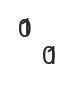

In [3]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",100)

import warnings
warnings.filterwarnings("ignore")

import src.models
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import encode_batch_weighted, onehot_batch_decode, onehot_decode, INT_TO_CHAR, HLAS, AA_KEYS
from src.data_processing import get_tensor_dataset, encode_batch, BL62_VALUES, BL62FREQ_VALUES, get_array_dataset
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from src.metrics import get_metrics, plot_roc_auc_fold, get_mean_roc_curve, get_pred_df, get_mean_pr_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.train_eval import kcv_tune_sklearn, evaluate_trained_models_sklearn, nested_kcv_train_sklearn
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump

from scipy.stats import ttest_ind, mannwhitneyu, wilcoxon
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
mpl.rcParams['figure.dpi'] = 180

RESDIR='../output/220906_analysis/'
BOOTDIR='../output/bootstrapping/'

if torch.cuda.is_available():
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device="cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'
    

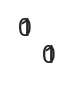

In [2]:
mpl.rcParams['figure.dpi'] = 180
sns.set_palette(HSV)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

# init

## reloading datasets

In [4]:
cedar = pd.read_csv('../data/partitioned_traindata/cedar_10fold.csv')
cedar['trainset']='cedar'

cedar_viral_old = pd.read_csv('../data/partitioned_traindata/cedar_viral_10fold.csv')
cedar_viral_old['trainset']='cedar_virus_old'

cedar_viral_more = pd.read_csv('../data/partitioned_traindata/new_cedar_viral_5fold.csv')
cedar_viral_more['trainset']='cedar_virus_new'
# USE PRIME FOR BASELINE VERIFICATION, PRIME_FOLD FOR ACTUAL TRAINING
prime_fold = pd.read_csv('../data/partitioned_traindata/prime_5fold.csv')
prime_fold['trainset']='prime'

prime = pd.read_excel('../data/partitioned_traindata/PRIME_dataset.xlsx', comment = '#', skiprows=2)
prime['len'] = prime['Mutant'].apply(len)
prime['HLA'] = prime['Allele'].apply(lambda x: 'HLA-'+x)

viral_only = pd.read_csv('../data/partitioned_traindata/viral_only_5fold.csv')
viral_only['trainset']='virus'

cedar_hp_uni = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_rank120_10fold.csv')
cedar_hp_uni['trainset']='cedar_hp_rank_uni'

cedar_hp_low = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_10fold.csv')
cedar_hp_low['trainset']='cedar_hp_rank_low'

cedar_hp_fold = pd.read_csv('../data/partitioned_traindata/cedar_hp_fold_balanced.csv')
cedar_hp_fold['trainset'] = 'cedar_balanced'

cedar_mut_fold = pd.read_csv('../data/partitioned_traindata/cedar_subst_mut_10fold.csv')

In [5]:
cedar_related = pd.read_csv('../data/mutant/220927_cedar_related_scored.csv')
prime_related = pd.read_csv('../data/mutant/220927_prime_neoepi_related_scored.csv')

In [6]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

## Baselines

3480


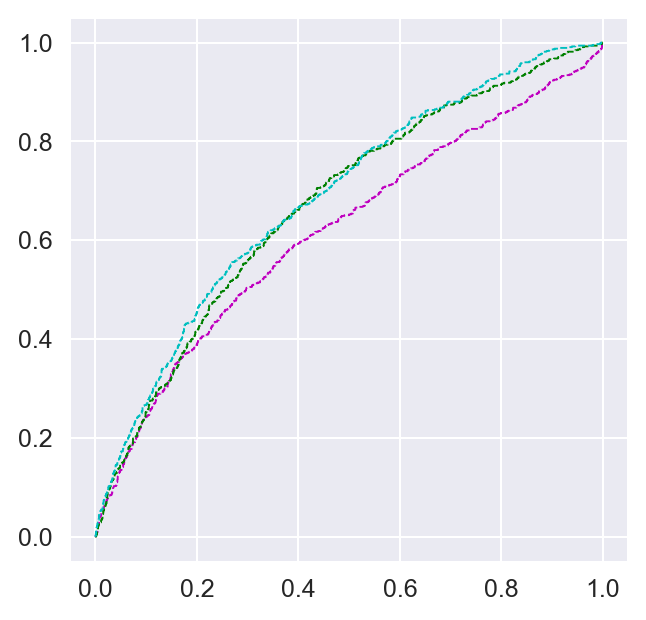

In [7]:
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
cedar_baseline = pd.read_csv('../data/baselines/cedar_baseline.csv')
cedar_related_baseline = pd.read_csv('../data/baselines/cedar_related_baseline.csv')
prime = pd.read_csv('../data/baselines/prime_baseline.csv')
prime_related_baseline = pd.read_csv('../data/baselines/prime_related_baseline.csv')
f,a = plt.subplots(1,1, figsize=(4,4))
plot_baseline_roc(a, cedar_baseline)

In [8]:
prime_related.columns.difference(prime_related_baseline.columns)

Index(['Allele', 'IEDB', 'Immunogenicity', 'MixMHCpred', 'NetMHCpanEL',
       'NetMHCpanEL_WT', 'PRIME', 'VHSE1', 'VHSE3', 'VHSE7', 'VHSE8',
       'aliphatic_index', 'boman', 'hydrophobicity', 'isoelectric_point'],
      dtype='object')

# retrain models

In [9]:
# BOOTSTRAP FUNCTIONS
from joblib import Parallel, delayed
from functools import partial
from src.metrics import get_metrics


def bootstrap_wrapper(y_score, y_true, seed):    
    np.random.seed(seed)
    sample_idx = np.random.randint(0, len(y_score), len(y_score))
    sample_score = y_score[sample_idx]
    sample_true = y_true[sample_idx]
    
    try:
        test_results = get_metrics(sample_true, sample_score)
    except:
        return pd.DataFrame(), (None, None, None, None)
    
    # Save to get mean curves after
    roc_curve = (test_results.pop('roc_curve'), test_results['auc'])
    # Same
    pr_curve = (test_results.pop('pr_curve'), test_results['prauc'])
    return pd.DataFrame(test_results, index=[0]), roc_curve 


def bootstrap_eval(y_score, y_true, n_rounds=10000, n_jobs=16):
    wrapper = partial(bootstrap_wrapper, 
                      y_score=y_score, y_true=y_true)
    print('Sampling')
    output = Parallel(n_jobs=n_jobs)(delayed(wrapper)(seed=seed) for seed in tqdm(range(n_rounds), desc='Bootstrapping rounds', position=1, leave=False))
    
    print('Making results DF and curves')
    result_df = pd.concat([x[0] for x in output])
    mean_roc_curve = get_mean_roc_curve([x[1] for x in output if x[1][0] is not None])
    # mean_pr_curve = get_mean_pr_curve([x[2] for x in output])
    return result_df, mean_roc_curve

def load_hyperparams(encoding_kwargs, train_dataset, MAPPING, model, blosum_matrix=None, weight = None):
    outdict = {'trainset': train_dataset['trainset'].unique()[0],
                       'model': MAPPING[model.__class__.__name__],
                       'weight': weight} # Hardcoded here
        
    outdict.update({k: v for k, v in encoding_kwargs.items() if k != 'blosum_matrix'})
    
    if blosum_matrix is not None:
        bl_name = 'BL62LO' if blosum_matrix['A'].dtype == np.int64 else 'BL62FREQ'
        outdict['blsm'] = bl_name
    cols_keys = [x for x in outdict.keys() if '_col' in x]
    for k in cols_keys:
        del outdict[k]
    outname = '_'.join([f'{k}{v}' for k, v in outdict.items() if k!='invert'])
        
    pkl_name = convert_path(os.path.join(f'../output/tuning/{MAPPING[model.__class__.__name__].lower()}_bootstrap', (outname + '.pkl')).replace('//', '/'))
    hyperparams = pkl_load(pkl_name)
    if 'max_depth' in hyperparams:
        if np.isnan(hyperparams['max_depth']):
            hyperparams['max_depth'] = None
        else:
    
            hyperparams['max_depth'] = int(hyperparams['max_depth'])
    
    for k in [x for x in hyperparams.keys() if x.startswith('n_')]:
        # converts n_estimators, n_layers, n_in, n_hidden, to int
        hyperparams[k] = int(hyperparams[k])
    return hyperparams

In [ ]:
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES
from src.train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
from sklearn.ensemble import RandomForestClassifier

# Setting kwargs
encoding_kwargs = {'max_len': 12,
                   'encoding': 'onehot',
                   'blosum_matrix': None,
                   'mask': False,  # Using Shannon ICs, true if both mask and name is "shannon"
                   'add_rank': True,
                   'add_aaprop': False,
                   'remove_pep': False,
                   'standardize': True}

# train on good ol' Cedar 10-fold dataset
train_dataset = cedar
train_dataset_balanced = cedar_hp_fold

enc_weight_results = {}
# Good ol' RandomForest
model = RandomForestClassifier(n_jobs=1, min_samples_leaf = 7)

for train_dataset, train_name in zip([cedar], 
                                      #cedar_hp_fold], 
                                     ['cedar']): 
                                      #'cedar_balanced']):
    train_dataset['trainset'] = 'cedar'
    enc_weight_results[train_name]={}
    # megaloops for encoding-weighting
    for encoding, blosum_matrix, blsm_name in tqdm(zip(['onehot','blosum', 'blosum'], 
                                                  [None, BL62_VALUES, BL62FREQ_VALUES],
                                                  ['onehot','BL62LO', 'BL62FREQ']),
                                                  desc = 'encoding', leave=True, position=0):
        
        encoding_kwargs['encoding']=encoding
        encoding_kwargs['blosum_matrix']=blosum_matrix
        enc_weight_results[train_name][blsm_name] = {}
        for invert in [True, False]:  
            for ic_name, ics_dict in tqdm(zip(['Mask', 'KL', 'None', 'Shannon'], [ics_shannon, ics_kl, None, ics_shannon]),
                                     desc = 'Weighting', leave=True, position=1):  
                # Set args
                encoding_kwargs['invert'] = invert
                encoding_kwargs['mask'] = True if 'Mask' in ic_name else False
                trainset_name = train_dataset.trainset.unique().item()
                # Load params
                hyperparams = load_hyperparams(encoding_kwargs, train_dataset, MAPPING, model, blosum_matrix, weight=ic_name)
                if invert:
                    if ic_name=='None':
                        continue
                    ic_name = 'Inverted '+ic_name
                # Make result dict
                enc_weight_results[train_name][blsm_name][ic_name]={}
                model.set_params(**hyperparams)
                #######################    RUN    ########################
                trained_models, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model, ics_dict=ics_dict,
                                                                encoding_kwargs=encoding_kwargs)
                enc_weight_results[train_name][blsm_name][ic_name]['model'] = trained_models


# External neoepi dataset

In [11]:
ibel_neoepi = pd.read_csv('../data/mutant/ibel_neoepitopes_cio_mhc_25aa.csv', sep = '\t')
ibel_neoepi.rename(columns={'Mut_peptide':'Peptide',
                            'HLA_allele': 'HLA',
                            'Mut_Rnk_EL': 'trueHLA_EL_rank',
                            'Target':'agg_label'}, inplace=True)
ibel_neoepi.head()

,n,Patient,Peptide,Norm_peptide,agg_label,ELISPOT_Log_Max_Min,Promiscuity,HLA,Allele_Frequency,Mismatches,Chr,Genomic_Position,Genomic_Position_vcf,Ref,Alt,Mutation_Consequence,Protein_position,Gene_Symbol,Gene_ID,Transcript_ID,Proteome_Peptide_Match,Expression_Level,Expression_score,Mut_Of,Mut_Gp,Mut_Gl,Mut_Ip,Mut_Il,Mut_Icore,trueHLA_EL_rank,Norm_Core,Norm_Of,Norm_Gp,Norm_Gl,Norm_Ip,Norm_Il,Norm_Icore,Norm_Rnk_EL,Mut_protein_sequence,Norm_protein_sequence
0,1,5,ATPSRVPGF,ATPSRVPGS,0,0.00,"{'HLA-C07:01', 'HLA-C07:02'}",HLA-C07:02,0.284,1,2,29003619-29003620,29003619,CC,TT,M,256,TOGARAM2,ENSG00000189350,ENST00000379558,No,0.198243748,0.289705,0,0,0,0,0,ATPSRVPGF,0.8692,ATPSRVPGS,0,0,0,0,0,ATPSRVPGS,35.9875,SLGAIVIPPIPKARTVAATPSRVPGFLPSPLPPGQGVLTGLRAPRT...,SLGAIVIPPIPKARTVAATPSRVPGSLPSPLPPGQGVLTGLRAPRT...
1,2,5,LRMDMLASF,LRMDMLAST,0,0.00,"{'HLA-B18:01', 'HLA-C07:01', 'HLA-C07:02'}",HLA-C07:02,0.385,1,19,55391569-55391570,55391569,AC,TT,M,114,RPL28,ENSG00000108107,ENST00000558815,No,503.78995,1.000000,0,0,0,0,0,LRMDMLASF,0.0188,LRMDMLAST,0,0,0,0,0,LRMDMLAST,4.6861,TLSSIRHMIRKNKYRPDLRMDMLASFGSGLCCSVAVQPWASSSTSL...,TLSSIRHMIRKNKYRPDLRMDMLASTGSGLCCSVAVQPWASSSTSL...
2,3,5,YLFSREKMYL,YPFSREKMYL,0,0.00,{'HLA-A02:01'},HLA-A02:01,0.287,1,12,5832476-5832477,5832476,GG,AA,M,251251255,ANO2,ENSG00000047617,"ENST00000327087,ENST00000356134,ENST00000546188",No,0.03652423673296,0.135682,0,4,1,0,0,YLFSREKMYL,0.1491,YPFSEKMYL,0,4,1,0,0,YPFSREKMYL,17.0926,LQKLSSHLQPRVPEHSNNKMKNLSYLFSREKMYLYNIQEKDTFFDN...,LQKLSSHLQPRVPEHSNNKMKNLSYPFSREKMYLYNIQEKDTFFDN...
3,4,5,KTGYTGVFR,KTGYTGVFG,1,0.43,{'HLA-A03:01'},HLA-A03:01,0.422,1,4,125468520,125468520,G,A,M,2233,FAT4,ENSG00000196159,ENST00000335110,No,0.709518500865377,0.669325,0,0,0,0,0,KTGYTGVFR,0.5055,KTGYTGVFG,0,0,0,0,0,KTGYTGVFG,16.5815,KNGAICQNFPGSFNCVCKTGYTGVFRKHCELNSYGFEELSYMEFPS...,KNGAICQNFPGSFNCVCKTGYTGVFGKHCELNSYGFEELSYMEFPS...
4,5,5,EHMGMVLLL,EHMGMVLLP,1,0.50,"{'HLA-C07:02', 'HLA-C07:01'}",HLA-C07:01,0.350,1,1,31792268,31792268,G,A,M,463970406970,SPOCD1,ENSG00000134668,"ENST00000257100,ENST00000360482,ENST0000045275...",No,0.182573095126972,0.275285,0,0,0,0,0,EHMGMVLLL,0.5250,EHMGMVLLP,0,0,0,0,0,EHMGMVLLP,19.9636,LLYSYLNDRQRHGLASVEHMGMVLLLLPAFQPLPTRLRPLGGPGLW...,LLYSYLNDRQRHGLASVEHMGMVLLPLPAFQPLPTRLRPLGGPGLW...


In [38]:
encoding_kwargs = {'max_len': 12,
                   'encoding': 'onehot',
                   'blosum_matrix': None,
                   'mask': False,  # Using Shannon ICs, true if both mask and name is "shannon"
                   'add_rank': True,
                   'add_aaprop': False,
                   'remove_pep': False,
                   'standardize': True}

for trainset, v1 in enc_weight_results.items():
    traindataset= cedar if trainset=='cedar' else cedar_hp_fold
    for encoding, v2 in v1.items():
        for weight, v3 in v2.items():
            ics_dict = ics_kl if 'KL' in weight else ics_shannon if ('Mask' in weight or 'Mask' in weight) else None
            encoding_kwargs['encoding']= 'onehot' if encoding=="onehot" else 'blosum'
            encoding_kwargs['blosum_matrix']=blosum_matrix
            # Set args
            encoding_kwargs['invert'] = invert
            encoding_kwargs['mask'] = True if 'Mask' in ic_name else False
            test_results, preds_df = evaluate_trained_models_sklearn(ibel_neoepi, v3['model'], ics_dict, traindataset, encoding_kwargs, 
                                            concatenated=True, only_concat=True)
            enc_weight_results[trainset][encoding][weight]['neoepi_results'] = test_results
            enc_weight_results[trainset][encoding][weight]['neoepi_preds']= preds_df
            print(trainset, encoding, weight, round(test_results['concatenated']['auc'],4))

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar onehot Inverted Mask 0.5711


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar onehot Inverted KL 0.5066


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar onehot Inverted Shannon 0.5028


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar onehot Mask 0.5581


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar onehot KL 0.6177


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar onehot None 0.5908


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar onehot Shannon 0.6098


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar BL62LO Inverted Mask 0.6014


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar BL62LO Inverted KL 0.5026


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar BL62LO Inverted Shannon 0.5115


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar BL62LO Mask 0.5891


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar BL62LO KL 0.5882


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar BL62LO None 0.5804


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar BL62LO Shannon 0.5867


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar BL62FREQ Inverted Mask 0.572


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar BL62FREQ Inverted KL 0.5414


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar BL62FREQ Inverted Shannon 0.5492


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar BL62FREQ Mask 0.5777


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar BL62FREQ KL 0.582


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar BL62FREQ None 0.5489


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar BL62FREQ Shannon 0.5752


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar_balanced onehot Inverted Mask 0.5861


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar_balanced onehot Inverted KL 0.5372


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar_balanced onehot Inverted Shannon 0.5386


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar_balanced onehot Mask 0.5548


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar_balanced onehot KL 0.6169


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar_balanced onehot None 0.6036


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar_balanced onehot Shannon 0.6149


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar_balanced BL62LO Inverted Mask 0.5769


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar_balanced BL62LO Inverted KL 0.528


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar_balanced BL62LO Inverted Shannon 0.5444


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar_balanced BL62LO Mask 0.5925


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar_balanced BL62LO KL 0.5692


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar_balanced BL62LO None 0.5944


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar_balanced BL62LO Shannon 0.5945


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar_balanced BL62FREQ Inverted Mask 0.5765


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar_balanced BL62FREQ Inverted KL 0.5323


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar_balanced BL62FREQ Inverted Shannon 0.5383


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar_balanced BL62FREQ Mask 0.5794


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar_balanced BL62FREQ KL 0.5847


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar_balanced BL62FREQ None 0.5579


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

cedar_balanced BL62FREQ Shannon 0.5874


In [45]:
from copy import deepcopy
ibel_results = pd.DataFrame()
for trainset, v1 in enc_weight_results.items():
    for encoding, v2 in v1.items():
        for weight, v3 in v2.items():
            x = deepcopy(v3['neoepi_results']['concatenated'])
            del x['roc_curve']
            del x['pr_curve']
            tmp = pd.DataFrame(x, index=[0])
            tmp['trainset']=trainset
            tmp['encoding']=encoding
            tmp['weight']=weight
            ibel_results = ibel_results.append(tmp, ignore_index=True)
ibel_results.reset_index(drop=True,inplace=True)

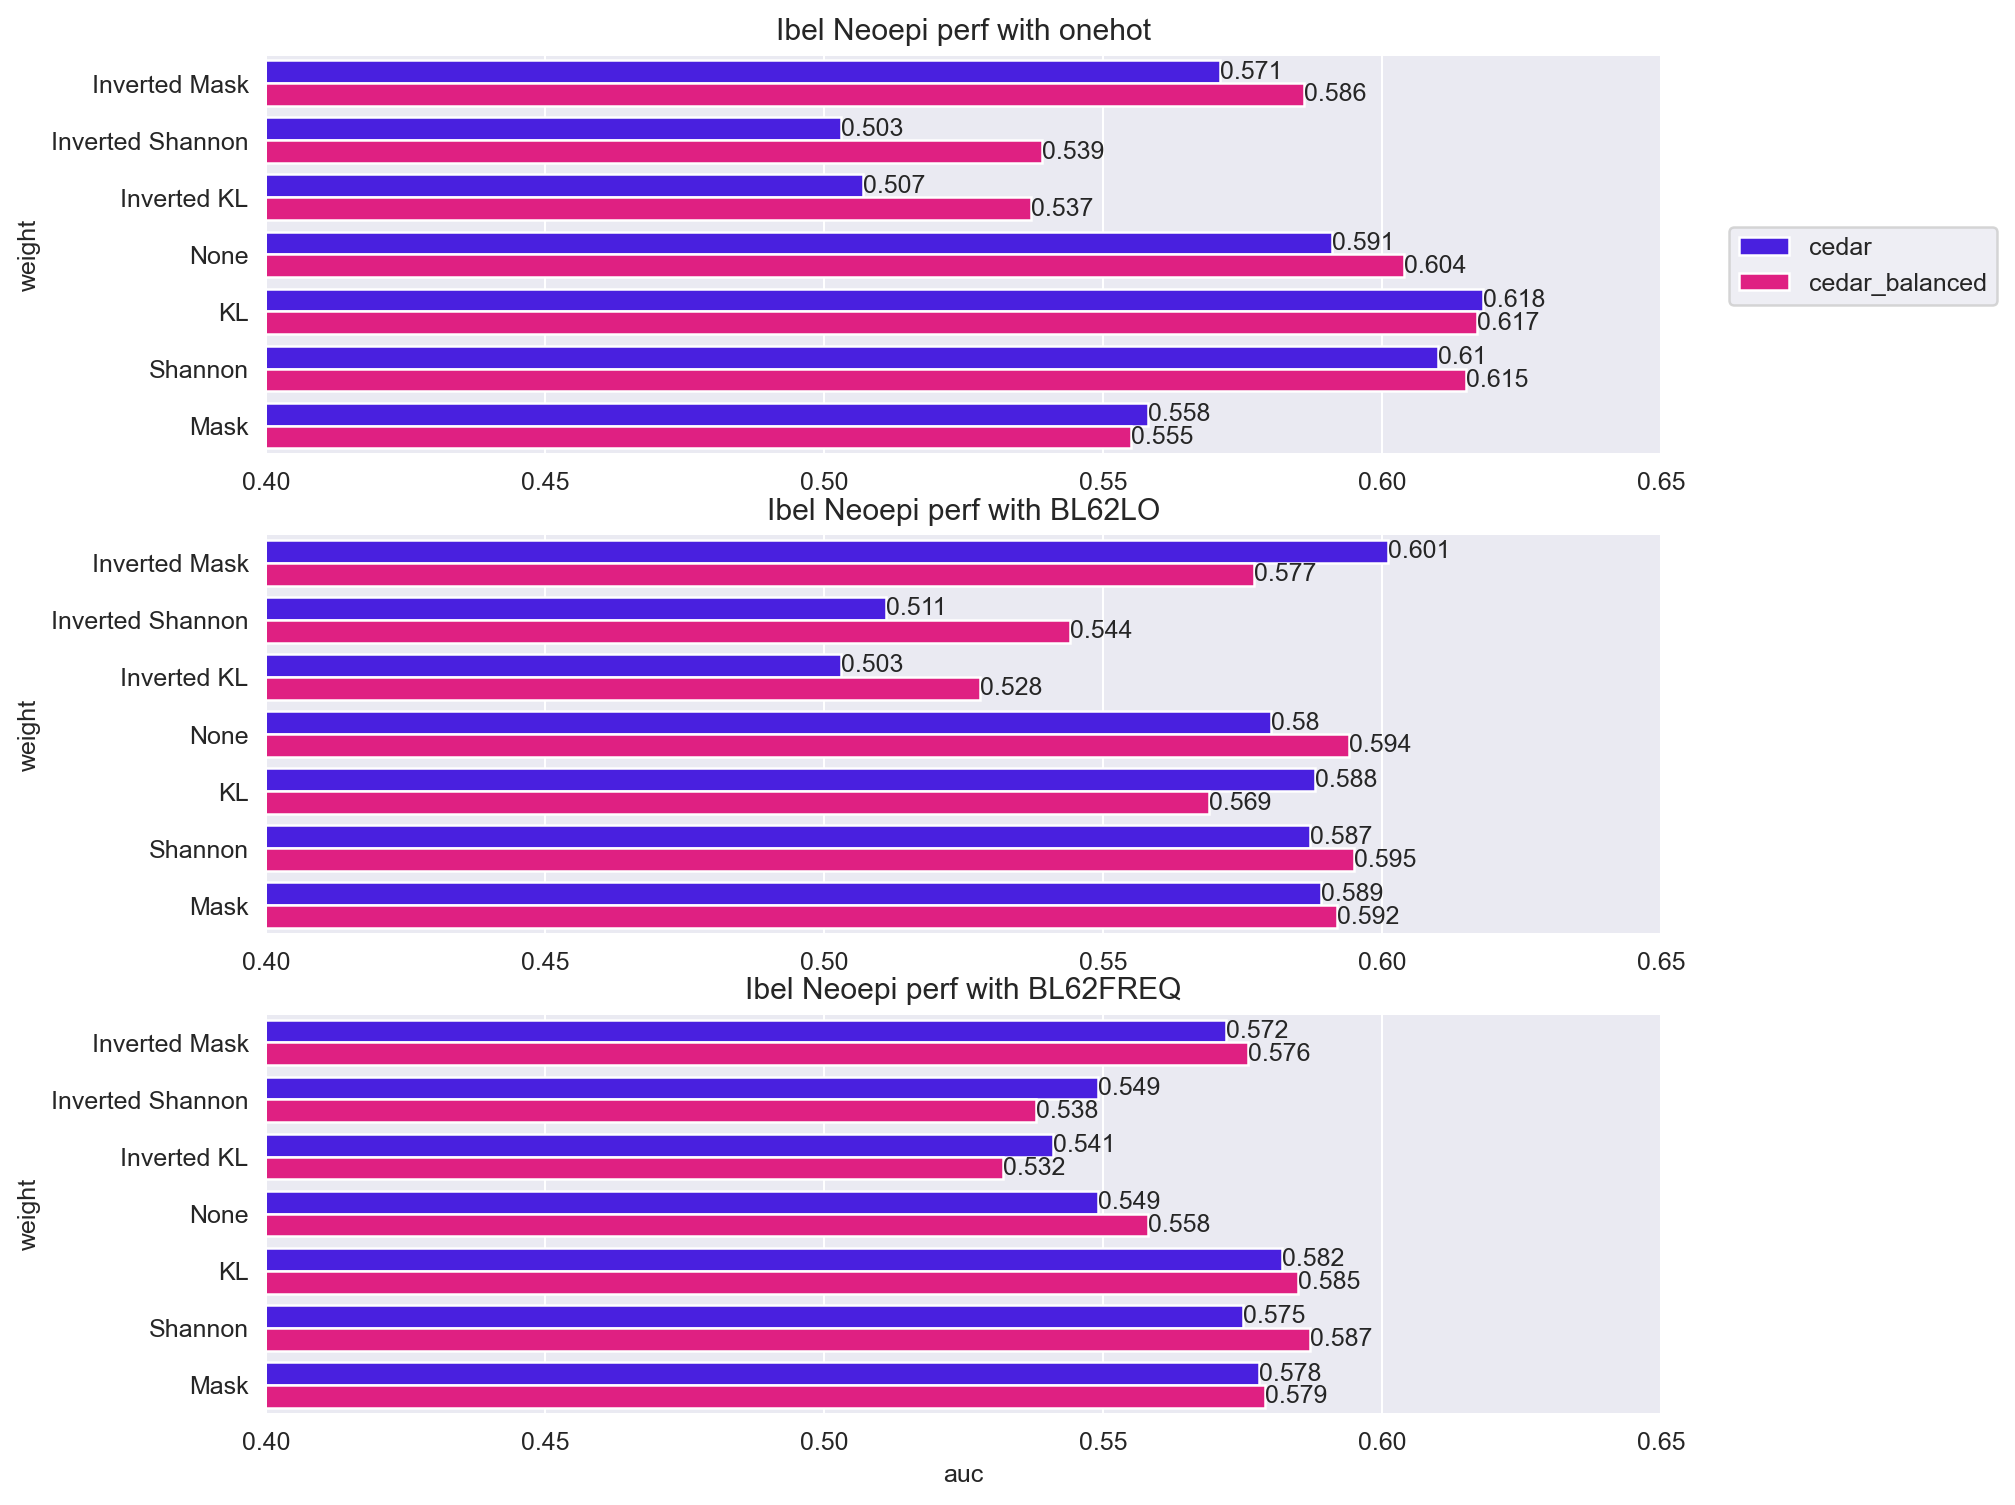

In [84]:
f,a = plt.subplots(3,1, figsize=(10,10))
sns.set_palette(HSV)
for i, encoding in enumerate(['onehot', 'BL62LO', 'BL62FREQ']):
    tm = ibel_results.query('encoding==@encoding')
    tm['auc']=tm['auc'].apply(lambda x: round(x,3))
    sns.barplot(data=tm, x='auc', y='weight', hue='trainset', order=['Inverted Mask', 'Inverted Shannon', 'Inverted KL', 
                                                                     'None', 'KL', 'Shannon', 'Mask'], ax=a[i], orient='h')
    a[i].set_title(f'Ibel Neoepi perf with {encoding}')
    if i <2 : 
        a[i].legend([], frameon=False)
        a[i].set_xlabel('')
    else:
        a[i].legend(bbox_to_anchor=(1.25, 3))
    a[i].set_xlim([.4, .65])
    a[i].bar_label(a[i].containers[0])
    a[i].bar_label(a[i].containers[1])
f.tight_layout()

# Only A0201

In [15]:
from sklearn.model_selection import StratifiedKFold
cedar_a0201 = cedar.query('HLA=="HLA-A02:01"')
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=13)
for i, (train, test) in enumerate(kf.split(cedar_a0201, cedar_a0201['agg_label'], groups = cedar_a0201['agg_label'].values)):
    cedar_a0201.iloc[test, cedar_a0201.columns.get_loc('fold')] = i
cedar_a0201.groupby(['fold','agg_label']).agg(count=('Peptide', 'count'))

count
fold agg_label       
0    0             99
     1             31
1    0             99
     1             31
2    0             99
     1             31
3    0             99
     1             31
4    0             99
     1             30
5    0             99
     1             30
6    0             99
     1             30
7    0             99
     1             30
8    0             99
     1             30
9    0             99
     1             30

In [16]:
prime_a0201.columns

Index(['Peptide', 'WT_peptide', 'Allele', 'HLA', 'trueHLA_EL_rank',
       'agg_label', 'len', 'nnalign_score', 'MixMHCrank', 'PRIME_score',
       'MixMHCallele', 'StudyOrigin', 'IEDB'],
      dtype='object')

In [17]:
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES
from src.train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
from sklearn.ensemble import RandomForestClassifier

# Here reload data in case
cedar_related = pd.read_csv('../data/mutant/220927_cedar_related_scored.csv')
prime_related = pd.read_csv('../data/mutant/220927_prime_neoepi_related_scored.csv')
prime_a0201 = prime.query('HLA=="HLA-A0201"').rename(columns = {'Mutant':'Peptide',
                                                                'Immunogenicity':'agg_label',
                                                                'NetMHCpanEL':'trueHLA_EL_rank'})
# Setting kwargs
encoding_kwargs = {'max_len': 12,
                   'encoding': 'onehot',
                   'blosum_matrix': None,
                   'mask': False,  # Using Shannon ICs, true if both mask and name is "shannon"
                   'add_rank': True,
                   'add_aaprop': False,
                   'remove_pep': False,
                   'standardize': True}

train_dataset = cedar_a0201
train_dataset['trainset']='cedar'
results_a0201 = {}
# Good ol' RandomForest
model = RandomForestClassifier(n_jobs=1, min_samples_leaf = 7)

    # megaloops for encoding-weighting
for encoding, blosum_matrix, blsm_name in tqdm(zip(['onehot','blosum', 'blosum'], 
                                              [None, BL62_VALUES, BL62FREQ_VALUES],
                                              ['onehot','BL62LO', 'BL62FREQ']),
                                              desc = 'encoding', leave=True, position=0):

    encoding_kwargs['encoding']=encoding
    encoding_kwargs['blosum_matrix']=blosum_matrix
    results_a0201[blsm_name] = {}
    for invert in [True, False]:  
        for ic_name, ics_dict in tqdm(zip(['Mask', 'KL', 'None', 'Shannon'], [ics_shannon, ics_kl, None, ics_shannon]),
                                 desc = 'Weighting', leave=True, position=1):  
            # Set args
            encoding_kwargs['invert'] = invert
            encoding_kwargs['mask'] = True if 'Mask' in ic_name else False
            trainset_name = train_dataset.trainset.unique().item()
            # Load params
            hyperparams = load_hyperparams(encoding_kwargs, train_dataset, MAPPING, model, blosum_matrix, weight=ic_name)
            if invert:
                if ic_name=='None':
                    continue
                ic_name = 'Inverted '+ic_name
            # Make result dict
            results_a0201[blsm_name][ic_name]={}
            model.set_params(**hyperparams)
            #######################    RUN    ########################
            trained_models, train_metrics, _ = nested_kcv_train_sklearn(cedar_a0201, model, ics_dict=ics_dict,
                                                            encoding_kwargs=encoding_kwargs)
            
            test_results, preds_df = evaluate_trained_models_sklearn(ibel_neoepi, trained_models, ics_dict, cedar_a0201, encoding_kwargs, 
                                            concatenated=True, only_concat=True, n_jobs=9)
            results_a0201[blsm_name][ic_name]['neoepi_results'] = test_results
            results_a0201[blsm_name][ic_name]['neoepi_preds']= preds_df
            
            test_results, preds_df = evaluate_trained_models_sklearn(prime_a0201, trained_models, ics_dict, cedar_a0201, encoding_kwargs, 
                                            concatenated=True, only_concat=True, n_jobs=9)
            results_a0201[blsm_name][ic_name]['prime_a0201_results'] = test_results
            results_a0201[blsm_name][ic_name]['prime_a0201_preds']= preds_df
            
            test_results, preds_df = evaluate_trained_models_sklearn(cedar_related, trained_models, ics_dict, cedar_a0201, encoding_kwargs, 
                                            concatenated=True, only_concat=True, n_jobs=9)
            results_a0201[blsm_name][ic_name]['cedar_related_results'] = test_results
            results_a0201[blsm_name][ic_name]['cedar_related_preds']= preds_df
            
            test_results, preds_df = evaluate_trained_models_sklearn(prime_related, trained_models, ics_dict, cedar_a0201, encoding_kwargs, 
                                            concatenated=True, only_concat=True, n_jobs=9)
            results_a0201[blsm_name][ic_name]['prime_related_results'] = test_results
            results_a0201[blsm_name][ic_name]['prime_related_preds']= preds_df
            results_a0201[blsm_name][ic_name]['model'] = trained_models
            k = results_a0201[blsm_name][ic_name]
            print(encoding, ic_name, '\nneoepi AUC:\t',k['neoepi_results']['concatenated']['auc'], '\tprimeA02021 AUC:\t', k['prime_a0201_results']['concatenated']['auc'],
                  '\tcedarRelated AUC:\t', k['cedar_related_results']['concatenated']['auc'], '\tprimeRelated AUC:\t', k['prime_related_results']['concatenated']['auc'])
pkl_dump(results_a0201, './results_a0201.pkl')

encoding: 0it [00:00, ?it/s]

Weighting: 0it [00:00, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

onehot Inverted Mask 
neoepi AUC:	 0.572302036199095 	primeA02021 AUC:	 0.6622486162606636 	cedarRelated AUC:	 0.6251792030421254 	primeRelated AUC:	 0.6681961288889618


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

onehot Inverted KL 
neoepi AUC:	 0.5918099547511313 	primeA02021 AUC:	 0.6570640986142584 	cedarRelated AUC:	 0.6378852925323236 	primeRelated AUC:	 0.6525388014912579


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

onehot Inverted Shannon 
neoepi AUC:	 0.5877488687782806 	primeA02021 AUC:	 0.6556709613729768 	cedarRelated AUC:	 0.6374272084490844 	primeRelated AUC:	 0.6509390467123359


Weighting: 0it [00:00, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

onehot Mask 
neoepi AUC:	 0.5930995475113121 	primeA02021 AUC:	 0.6586468896612423 	cedarRelated AUC:	 0.6362885602450652 	primeRelated AUC:	 0.6867373947831416


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

onehot KL 
neoepi AUC:	 0.5761934389140272 	primeA02021 AUC:	 0.65080476710766 	cedarRelated AUC:	 0.6348650351133335 	primeRelated AUC:	 0.6712661963327098


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

onehot None 
neoepi AUC:	 0.5656278280542986 	primeA02021 AUC:	 0.6645116113157311 	cedarRelated AUC:	 0.636158229257249 	primeRelated AUC:	 0.668983648482529


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

onehot Shannon 
neoepi AUC:	 0.5853789592760181 	primeA02021 AUC:	 0.6480948608170293 	cedarRelated AUC:	 0.6354863759076269 	primeRelated AUC:	 0.6742168934316691


Weighting: 0it [00:00, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

blosum Inverted Mask 
neoepi AUC:	 0.589485294117647 	primeA02021 AUC:	 0.6090284854581723 	cedarRelated AUC:	 0.6415484114743502 	primeRelated AUC:	 0.6450929478531493


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

blosum Inverted KL 
neoepi AUC:	 0.5524151583710407 	primeA02021 AUC:	 0.6067805679113034 	cedarRelated AUC:	 0.5804411617160451 	primeRelated AUC:	 0.6236229837245509


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

blosum Inverted Shannon 
neoepi AUC:	 0.5581900452488688 	primeA02021 AUC:	 0.6017893610813965 	cedarRelated AUC:	 0.5782714028358106 	primeRelated AUC:	 0.621643483485744


Weighting: 0it [00:00, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

blosum Mask 
neoepi AUC:	 0.6638631221719457 	primeA02021 AUC:	 0.6149029319011471 	cedarRelated AUC:	 0.6487902854570948 	primeRelated AUC:	 0.6785401341453654


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

blosum KL 
neoepi AUC:	 0.6401923076923077 	primeA02021 AUC:	 0.6071092698481707 	cedarRelated AUC:	 0.6407543759228336 	primeRelated AUC:	 0.6641085476985742


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

blosum None 
neoepi AUC:	 0.6234671945701358 	primeA02021 AUC:	 0.6210172496500302 	cedarRelated AUC:	 0.6524613217793576 	primeRelated AUC:	 0.6571009816794515


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

blosum Shannon 
neoepi AUC:	 0.6438518099547511 	primeA02021 AUC:	 0.6031257227193124 	cedarRelated AUC:	 0.6411948897029595 	primeRelated AUC:	 0.6653610583521207


Weighting: 0it [00:00, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

blosum Inverted Mask 
neoepi AUC:	 0.555237556561086 	primeA02021 AUC:	 0.6192427004838694 	cedarRelated AUC:	 0.6389322214400344 	primeRelated AUC:	 0.6378720524834598


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

blosum Inverted KL 
neoepi AUC:	 0.5062443438914027 	primeA02021 AUC:	 0.6182205148907759 	cedarRelated AUC:	 0.5556833484270447 	primeRelated AUC:	 0.5798233106859882


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

blosum Inverted Shannon 
neoepi AUC:	 0.5050113122171945 	primeA02021 AUC:	 0.6171275181277414 	cedarRelated AUC:	 0.5580361492044354 	primeRelated AUC:	 0.5812411441317896


Weighting: 0it [00:00, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

blosum Mask 
neoepi AUC:	 0.632596153846154 	primeA02021 AUC:	 0.6189428460288132 	cedarRelated AUC:	 0.6437148480301013 	primeRelated AUC:	 0.6713819554181083


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

blosum KL 
neoepi AUC:	 0.6089366515837105 	primeA02021 AUC:	 0.62102605507826 	cedarRelated AUC:	 0.6289482727301126 	primeRelated AUC:	 0.6602085863423628


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

blosum None 
neoepi AUC:	 0.575593891402715 	primeA02021 AUC:	 0.6210682639291251 	cedarRelated AUC:	 0.6391877759616105 	primeRelated AUC:	 0.6429818188661203


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

blosum Shannon 
neoepi AUC:	 0.6148529411764706 	primeA02021 AUC:	 0.6199655219473766 	cedarRelated AUC:	 0.628655147842613 	primeRelated AUC:	 0.6542403010186799
./results_a0201.pkl saved.


# Mutation score stuff

## defs

In [12]:
from src.data_processing import BL62, AA_KEYS
from src.mutation_tools import check_wt, get_anchor, get_mutation_type, get_mutation_pos, get_binder_type, get_anchor_mutation
# manually typing out this bs
mutation_matrix = pd.read_csv('../data/Matrices/mutation_matrix.csv', index_col=0).to_dict()

def get_blsm_mutation_score(mutation_positions, mutant, wildtype):
    """
    Done as the log of the sum of mutation scores
    """
    positions = [int(x) for x in mutation_positions.split(',')]
    # print(positions, mutant, wildtype, type(positions[0]), type(mutant), mutant[positions[0]], wildtype[positions[0]])
    # Here take sum and not product because might be set to zero
    score = np.sum([BL62[mutant[x]][wildtype[x]] for x in positions])
    if score == -np.inf or score==np.nan:
        return -1
    else:
        return score

def get_mutation_score(mutation_positions, mutant, wildtype):
    """
    Done as the log of the sum of mutation scores
    """
    positions = [int(x) for x in mutation_positions.split(',')]
    # Here take sum and not product because might be set to zero
    score = np.log(np.sum([mutation_matrix[mutant[x]][wildtype[x]] for x in positions]))
    if score == -np.inf or score==np.nan:
        return -1
    else:
        return score

In [13]:
cedar_related_fold = pd.read_csv('../data/partitioned_traindata/cedar_subst_mut_10fold.csv')
cedar_related_fold['blsm_mut_score'] = cedar_related_fold.apply(lambda x: get_blsm_mutation_score(x['mutation_position'], x['Peptide'], x['wild_type']), axis=1)
cedar_related_fold['mutation_score'] = cedar_related_fold.apply(lambda x: get_mutation_score(x['mutation_position'], x['Peptide'], x['wild_type']), axis=1)
cedar_related_fold['ratio_rank'] = cedar_related_fold['wt_EL_rank']/cedar_related_fold['trueHLA_EL_rank']
# prime
prime_related_baseline = prime_related_baseline.query('Peptide != wild_type')
prime_related_baseline['blsm_mut_score'] = prime_related_baseline.apply(lambda x: get_blsm_mutation_score(x['mutation_position'], x['Peptide'], x['wild_type']), axis=1)
prime_related_baseline['mutation_score'] = prime_related_baseline.apply(lambda x: get_mutation_score(x['mutation_position'], x['Peptide'], x['wild_type']), axis=1)
# Neoepi
ibel_neoepi['ratio_rank'] = ibel_neoepi['trueHLA_EL_rank']/ibel_neoepi['Norm_Rnk_EL']
ibel_neoepi['mutation_type'] = ibel_neoepi.apply(lambda x: get_mutation_type(x['Peptide'], x['Norm_peptide']), axis=1)
ibel_neoepi['mutation_position'] = ibel_neoepi.apply(lambda x: get_mutation_pos(x['Peptide'], x['Norm_peptide'], x['mutation_type']), axis=1)
ibel_neoepi['blsm_mut_score'] = ibel_neoepi.apply(lambda x: get_blsm_mutation_score(x['mutation_position'], x['Peptide'], x['Norm_peptide']), axis=1)
ibel_neoepi['mutation_score'] = ibel_neoepi.apply(lambda x: get_mutation_score(x['mutation_position'], x['Peptide'], x['Norm_peptide']), axis=1)

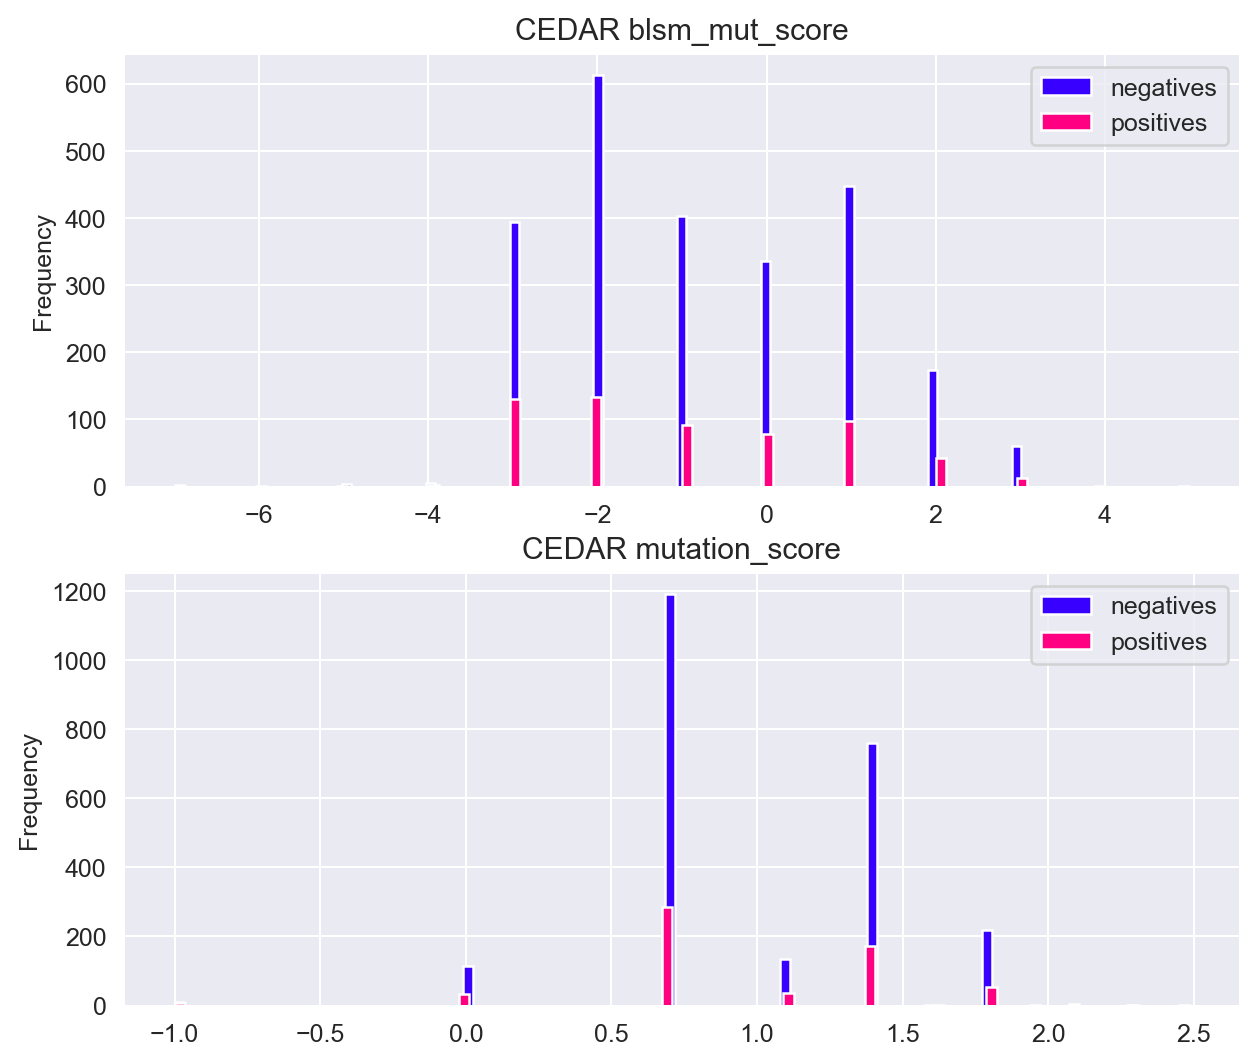

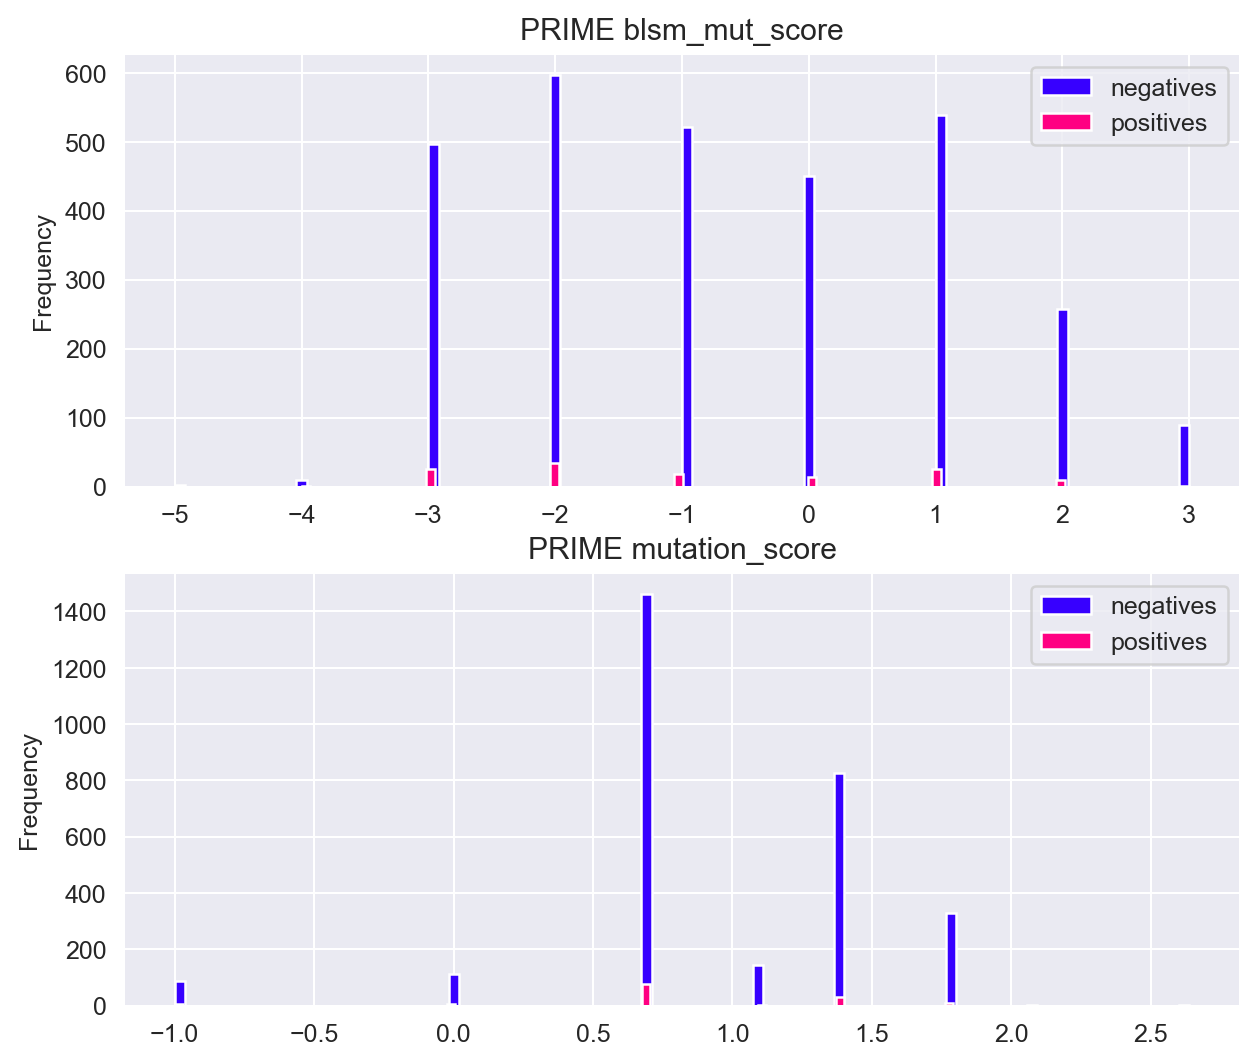

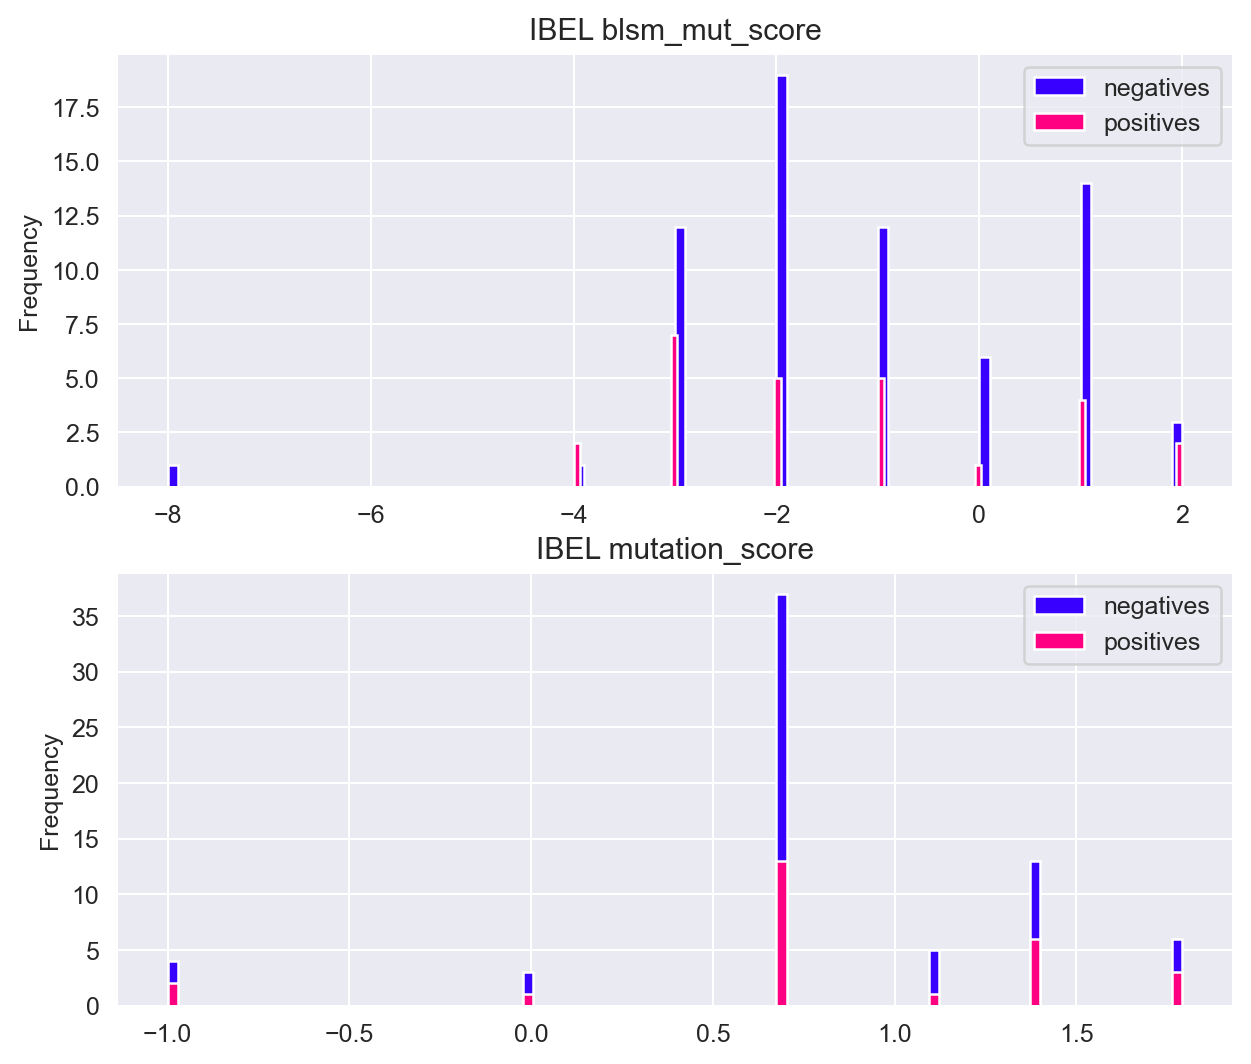

In [14]:
f,a = plt.subplots(2,1, figsize=(8,7))
for i, col in enumerate(['blsm_mut_score', 'mutation_score']):
    cedar_related_fold.query('agg_label==0')[col].plot(kind='hist', ax=a[i], label='negatives', bins=100)
    cedar_related_fold.query('agg_label==1')[col].plot(kind='hist', ax=a[i], label='positives', bins=100)
    a[i].set_title('CEDAR '+col)
    a[i].legend()
f,a = plt.subplots(2,1, figsize=(8,7))
for i, col in enumerate(['blsm_mut_score', 'mutation_score']):
    prime_related_baseline.query('agg_label==0')[col].plot(kind='hist', ax=a[i], label='negatives', bins=100)
    prime_related_baseline.query('agg_label==1')[col].plot(kind='hist', ax=a[i], label='positives', bins=100)
    a[i].set_title('PRIME '+col)
    a[i].legend()
f,a = plt.subplots(2,1, figsize=(8,7))
for i, col in enumerate(['blsm_mut_score', 'mutation_score']):
    ibel_neoepi.query('agg_label==0')[col].plot(kind='hist', ax=a[i], label='negatives', bins=100)
    ibel_neoepi.query('agg_label==1')[col].plot(kind='hist', ax=a[i], label='positives', bins=100)
    a[i].set_title('IBEL '+col)
    a[i].legend()

In [15]:
from src.data_processing import get_mutation_dataset
from src.metrics import get_metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from copy import deepcopy

def assert_encoding_kwargs(encoding_kwargs, mode_eval=False):
    """
    Assertion / checks for encoding kwargs and verify all the necessary key-values 
    are in
    """
    # Making a deep copy since dicts are mutable between fct calls
    encoding_kwargs = deepcopy(encoding_kwargs)
    if encoding_kwargs is None:
        encoding_kwargs = {'max_len': 12,
                           'encoding': 'onehot',
                           'blosum_matrix': None,
                           'standardize': False}
    essential_keys = ['max_len', 'encoding', 'blosum_matrix', 'standardize']
    assert all([x in encoding_kwargs.keys() for x in
                essential_keys]), f'Encoding kwargs don\'t contain the essential key-value pairs! ' \
                                  f"{'max_len', 'encoding', 'blosum_matrix', 'standardize'} are required."

    if mode_eval:
        if any([(x not in encoding_kwargs.keys()) for x in ['seq_col', 'hla_col', 'target_col', 'rank_col']]):
            encoding_kwargs.update({'seq_col': 'Peptide',
                                    'hla_col': 'HLA',
                                    'target_col': 'agg_label',
                                    'rank_col': 'trueHLA_EL_rank'})

        # This KWARGS not needed in eval mode since I'm using Pipeline and Wrapper
        del encoding_kwargs['standardize']
    return encoding_kwargs


def get_predictions(df, models, ics_dict, encoding_kwargs):
    """
    Args:
        models (list) : list of all the models for a given fold. Should be a LIST
        ics_dict (dict): weights or None
        encoding_kwargs: the kwargs needed to process the df
        metrics (dict):

    Returns:
        predictions_df (pd
        df (pd.DataFrame): DataFrame containing the Peptide-HLA pairs to evaluate
        models (list): A.DataFrame): Original DataFrame + a column predictions which are the scores + y_true
    """

    df = df.copy()

    # HERE NEED TO DO SWITCH CASES
    x, y = get_mutation_dataset(df, ics_dict, **encoding_kwargs)

    # Take the first model in the list and get its class
    model_class = models[0].__class__

    # If model is a scikit-learn model, get pred prob
    if issubclass(model_class, sklearn.base.BaseEstimator):
        average_predictions = [model.predict_proba(x)[:, 1] \
                               for model in models]
    # If models list is a torch model, use forward
    elif issubclass(model_class, nn.Module):
        x = torch.from_numpy(x)
        with torch.no_grad():
            average_predictions = [model(x).detach().cpu().numpy() for model in models]

    average_predictions = np.mean(np.stack(average_predictions), axis=0)
    # assert len(average_predictions)==len(df), f'Wrong shapes passed preds:{len(average_predictions)},df:{len(df)}'
    output_df = df.copy(deep=True)
    output_df['pred'] = average_predictions
    return output_df


# TRAIN WITH PARALLEL WRAPPER
def parallel_inner_train_wrapper(train_dataframe, x_test, base_model, ics_dict,
                                 encoding_kwargs, standardize, fold_out, fold_in):
    seed = fold_out * 10 + fold_in
    # Copy the base model, resets the seed
    model = sklearn.base.clone(base_model)
    model.set_params(random_state=seed)
    if standardize:
        model = Pipeline([('scaler', StandardScaler()), ('model', model)])

    # Here resets model weight at every fold, using the fold number (range(0, n_folds*(n_folds-1)) ) as seed
    # Query subset dataframe and get encoded data and targets
    train = train_dataframe.query('fold != @fold_out and fold != @fold_in').reset_index(drop=True)
    valid = train_dataframe.query('fold == @fold_in').reset_index(drop=True)
    # Get datasets
    x_train, y_train = get_mutation_dataset(train, ics_dict, **encoding_kwargs)
    x_valid, y_valid = get_mutation_dataset(valid, ics_dict, **encoding_kwargs)

    # Fit the model and append it to the list
    model.fit(x_train, y_train)

    # Get the prediction values on both the train and validation set
    y_train_pred, y_train_score = model.predict(x_train), model.predict_proba(x_train)[:, 1]
    y_val_pred, y_val_score = model.predict(x_valid), model.predict_proba(x_valid)[:, 1]
    # Get the metrics and save them
    train_metrics = get_metrics(y_train, y_train_score, y_train_pred)
    valid_metrics = get_metrics(y_valid, y_val_score, y_val_pred)
    y_pred_test = model.predict_proba(x_test)[:, 1]

    return model, train_metrics, valid_metrics, y_pred_test


def nested_kcv_train_mut(dataframe, base_model, ics_dict, encoding_kwargs: dict = None, n_jobs=None):
    """
    Args:
        dataframe:
        base_model:
        ics_dict:
        encoding_kwargs:

    Returns:
        models_fold
        train_results
        test_results
    """
    encoding_kwargs = assert_encoding_kwargs(encoding_kwargs, mode_eval=False)
    #
    models_dict = {}
    test_metrics = {}
    train_metrics = {}
    folds = sorted(dataframe.fold.unique())
    std = encoding_kwargs.pop('standardize')
    for fold_out in tqdm(folds, leave=False, desc='Outer fold', position=2):
        # Get test set & init models list to house all models trained in inner fold
        test = dataframe.query('fold == @fold_out').reset_index(drop=True)
        x_test, y_test = get_mutation_dataset(test, ics_dict, **encoding_kwargs)
        # For a given fold, all the models that are trained should be appended to this list
        inner_folds = sorted([f for f in folds if f != fold_out])
        n_jobs = len(inner_folds) if n_jobs is None else n_jobs
        # Create the sub-dict and put the model into the models dict
        train_wrapper_ = partial(parallel_inner_train_wrapper, train_dataframe=dataframe, x_test=x_test,
                                 base_model=base_model, ics_dict=ics_dict, encoding_kwargs=encoding_kwargs,
                                 standardize=std, fold_out=fold_out)
        output = Parallel(n_jobs=n_jobs)(
            delayed(train_wrapper_)(fold_in=fold_in) for fold_in in tqdm(inner_folds,
                                                                         desc='Inner Folds',
                                                                         leave=False, position=1))
        models_dict[fold_out] = [x[0] for x in output]
        train_tmp = [x[1] for x in output]
        valid_tmp = [x[2] for x in output]
        avg_prediction = [x[3] for x in output]
        avg_prediction = np.mean(np.stack(avg_prediction), axis=0)
        train_metrics[fold_out] = {k: {'train': v_train,
                                       'valid': v_valid} for k, v_train, v_valid in
                                   zip(inner_folds, train_tmp, valid_tmp)}
        test_metrics[fold_out] = get_metrics(y_test, avg_prediction)

    return models_dict, train_metrics, test_metrics


# EVAL WITH PARALLEL WRAPPER
def parallel_eval_wrapper(test_dataframe, models_list, ics_dict,
                          train_dataframe, encoding_kwargs, fold_out):
    # If no train dataframe provided and test_dataframe is partitioned,
    # It will eval on each of the folds
    if 'fold' in test_dataframe.columns and test_dataframe.equals(train_dataframe):
        test_df = test_dataframe.query('fold==@fold_out')
    else:
        test_df = test_dataframe.copy().reset_index(drop=True)

    if train_dataframe is not None and not train_dataframe.equals(test_dataframe):
        tmp = train_dataframe.query('fold != @fold_out')
        train_peps = tmp[encoding_kwargs['seq_col']].unique()
        test_df = test_df.query(f'{encoding_kwargs["seq_col"]} not in @train_peps')

    predictions_df = get_predictions(test_df, models_list, ics_dict, encoding_kwargs)
    test_metrics = get_metrics(predictions_df[encoding_kwargs['target_col']].values,
                               predictions_df['pred'].values)
    return predictions_df, test_metrics


def evaluate_trained_models_mut(test_dataframe, models_dict, ics_dict,
                                    train_dataframe=None,
                                    encoding_kwargs: dict = None,
                                    concatenated=False, only_concat=False):
    """

    Args:
        dataframe:
        models_dict:
        ics_dict:
        train_metrics (dict): Should be used if standardize in encoding_kwargs is True...
        encoding_kwargs:
        concatenated:
        only_concat:

    Returns:
        test_results
        predictions_df
    """
    encoding_kwargs = assert_encoding_kwargs(encoding_kwargs, mode_eval=True)
    # Wrapper and parallel evaluation
    eval_wrapper_ = partial(parallel_eval_wrapper, test_dataframe=test_dataframe, ics_dict=ics_dict,
                            train_dataframe=train_dataframe, encoding_kwargs=encoding_kwargs)

    output = Parallel(n_jobs=8)(delayed(eval_wrapper_)(fold_out=fold_out, models_list=models_list) \
                                                      for (fold_out, models_list) in tqdm(models_dict.items(),
                                                                                          desc='Eval Folds',
                                                                                          leave=False,
                                                                                          position=2))
    predictions_df = [x[0] for x in output]
    # print('here', len(predictions_df), len(predictions_df[0]))
    test_metrics = [x[1] for x in output]

    test_results = {k: v for k, v in zip(models_dict.keys(), test_metrics)}

    # Here simply concatenates it to get all the predictions from the folds
    predictions_df = pd.concat(predictions_df)

    # Here get the concat results
    if concatenated:
        test_results['concatenated'] = get_metrics(predictions_df[encoding_kwargs['target_col']].values,
                                                   predictions_df['pred'].values)
    # Either concatenated, or mean predictions
    else:
        # obj_cols = [x for x,y in zip(predictions_df.dtypes.index, predictions_df.dtypes.values) if y=='object']
        cols = [encoding_kwargs['seq_col'], encoding_kwargs['hla_col'], encoding_kwargs['target_col']]
        mean_preds = predictions_df.groupby(cols).agg(mean_pred=('pred', 'mean'))
        predictions_df = test_dataframe.merge(mean_preds, left_on=cols, right_on=cols, suffixes=[None, None])
    # print('there', len(predictions_df))

    if only_concat and concatenated:
        keys_del = [k for k in test_results if k != 'concatenated']
        for k in keys_del:
            del test_results[k]

    return test_results, predictions_df

## runs

In [ ]:
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES
from src.train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
from sklearn.ensemble import RandomForestClassifier
import itertools
# Setting kwargs
encoding_kwargs = {'max_len': 12,
                   'encoding': 'onehot',
                   'blosum_matrix': None,
                   'mask': False,  # Using Shannon ICs, true if both mask and name is "shannon"
                   'add_rank': True,
                   'add_aaprop': False,
                   'remove_pep': False,
                   'standardize': True}


results_related = {}
# Good ol' RandomForest
model = RandomForestClassifier(n_jobs=1, min_samples_leaf = 7)
train_dataset=cedar_related_fold

cols_ = ['blsm_mut_score', 'mutation_score', 'ratio_rank']
mcs = []
for L in range(1, len(cols_)+1):
    for mc in itertools.combinations(cols_, L):
        mcs.append(list(mc))
        
for mut_cols in tqdm(reversed(mcs), position=0, leave=True, desc='cols'):
    key = '-'.join(mut_cols)
    results_related[key]= {}
    print(key)
    # megaloops for encoding-weighting
    for encoding, blosum_matrix, blsm_name in tqdm(zip(['onehot','blosum', 'blosum'], 
                                                  [None, BL62_VALUES, BL62FREQ_VALUES],
                                                  ['onehot','BL62LO', 'BL62FREQ']),
                                                  desc = 'encoding', leave=True, position=1):
    
        encoding_kwargs['encoding']=encoding
        encoding_kwargs['blosum_matrix']=blosum_matrix
        
        results_related[key][blsm_name] = {}
        for invert in [True, False]:  
            for ic_name, ics_dict in tqdm(zip(['Mask', 'KL', 'None', 'Shannon'], [ics_shannon, ics_kl, None, ics_shannon]),
                                     desc = 'Weighting', leave=True, position=2):  
                # Set args
                encoding_kwargs['invert'] = invert
                encoding_kwargs['mask'] = True if 'Mask' in ic_name else False
                trainset_name = train_dataset.trainset.unique().item()
                # Load params
                hyperparams = load_hyperparams(encoding_kwargs, train_dataset, MAPPING, model, blosum_matrix, weight=ic_name)
                if invert:
                    if ic_name=='None':
                        continue
                    ic_name = 'Inverted '+ic_name
                # Make result dict
                results_related[key][blsm_name][ic_name]={}
                model.set_params(**hyperparams)
                #######################    RUN    ########################
                encoding_kwargs['mut_col']=mut_cols
                trained_models, train_metrics, _ = nested_kcv_train_mut(cedar_related_fold, model, ics_dict=ics_dict,
                                                                encoding_kwargs=encoding_kwargs)
                # Eval on ibel
                test_results, preds_df = evaluate_trained_models_mut(ibel_neoepi, trained_models, ics_dict, cedar_related_fold, encoding_kwargs, 
                                                concatenated=True, only_concat=True)
                del test_results['concatenated']['roc_curve']
                del test_results['concatenated']['pr_curve']
                results_related[key][blsm_name][ic_name]['neoepi_results'] = test_results
                results_related[key][blsm_name][ic_name]['neoepi_preds']= preds_df
                # Eval on cedar related subst mut
                test_results, preds_df = evaluate_trained_models_mut(cedar_related_fold, trained_models, ics_dict, cedar_related_fold, encoding_kwargs, 
                                                concatenated=True, only_concat=True)
                del test_results['concatenated']['roc_curve']
                del test_results['concatenated']['pr_curve']
                results_related[key][blsm_name][ic_name]['cedar_related_results'] = test_results
                results_related[key][blsm_name][ic_name]['cedar_related_preds']= preds_df
                # Eval on prime related subst mut
                test_results, preds_df = evaluate_trained_models_mut(prime_related_baseline, trained_models, ics_dict, cedar_related_fold, encoding_kwargs, 
                                                concatenated=True, only_concat=True)
                del test_results['concatenated']['roc_curve']
                del test_results['concatenated']['pr_curve']
                results_related[key][blsm_name][ic_name]['prime_related_results'] = test_results
                results_related[key][blsm_name][ic_name]['prime_related_preds']= preds_df
                # Save the models
                results_related[key][blsm_name][ic_name]['model'] = trained_models
                # prints
                k = results_related[key][blsm_name][ic_name]
                print(key, encoding, ic_name, '\nneoepi AUC:\t',k['neoepi_results']['concatenated']['auc'],
                      '\tcedarRelated AUC:\t', k['cedar_related_results']['concatenated']['auc'], 
                      '\tprimeRelated AUC:\t', k['prime_related_results']['concatenated']['auc'])

cols: 0it [00:00, ?it/s]

blsm_mut_score-mutation_score-ratio_rank


encoding: 0it [00:00, ?it/s]

Weighting: 0it [00:00, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

blsm_mut_score-mutation_score-ratio_rank onehot Inverted Mask 
neoepi AUC:	 0.6023310387984981 	cedarRelated AUC:	 0.7057011692150978 	primeRelated AUC:	 0.6616316829273731


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

blsm_mut_score-mutation_score-ratio_rank onehot Inverted KL 
neoepi AUC:	 0.5796151439299124 	cedarRelated AUC:	 0.7231155264235969 	primeRelated AUC:	 0.6344638426379247


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

blsm_mut_score-mutation_score-ratio_rank onehot Inverted Shannon 
neoepi AUC:	 0.580921464330413 	cedarRelated AUC:	 0.7223861510014726 	primeRelated AUC:	 0.6346542576244627


Weighting: 0it [00:00, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

blsm_mut_score-mutation_score-ratio_rank onehot Mask 
neoepi AUC:	 0.5663094493116395 	cedarRelated AUC:	 0.7088075888260239 	primeRelated AUC:	 0.6684700838785768


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

blsm_mut_score-mutation_score-ratio_rank onehot KL 
neoepi AUC:	 0.6001877346683355 	cedarRelated AUC:	 0.714486198611557 	primeRelated AUC:	 0.6586968999495131


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

blsm_mut_score-mutation_score-ratio_rank onehot None 
neoepi AUC:	 0.6054443053817271 	cedarRelated AUC:	 0.713655098154279 	primeRelated AUC:	 0.6672699304833942


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

blsm_mut_score-mutation_score-ratio_rank onehot Shannon 
neoepi AUC:	 0.61034887359199 	cedarRelated AUC:	 0.7146709644917347 	primeRelated AUC:	 0.659606447145776


Weighting: 0it [00:00, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

blsm_mut_score-mutation_score-ratio_rank blosum Inverted Mask 
neoepi AUC:	 0.5985215894868585 	cedarRelated AUC:	 0.6949889002070486 	primeRelated AUC:	 0.630938470487006


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

blsm_mut_score-mutation_score-ratio_rank blosum Inverted KL 
neoepi AUC:	 0.6067819148936171 	cedarRelated AUC:	 0.689850055914169 	primeRelated AUC:	 0.6078179269470947


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

blsm_mut_score-mutation_score-ratio_rank blosum Inverted Shannon 
neoepi AUC:	 0.5967537546933668 	cedarRelated AUC:	 0.6889836630977557 	primeRelated AUC:	 0.6065539081143956


Weighting: 0it [00:00, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

blsm_mut_score-mutation_score-ratio_rank blosum Mask 
neoepi AUC:	 0.6202753441802253 	cedarRelated AUC:	 0.6923869537296413 	primeRelated AUC:	 0.669343822130105


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

blsm_mut_score-mutation_score-ratio_rank blosum KL 
neoepi AUC:	 0.6040597622027535 	cedarRelated AUC:	 0.6862502352823943 	primeRelated AUC:	 0.6572060665225351


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

blsm_mut_score-mutation_score-ratio_rank blosum None 
neoepi AUC:	 0.6269633917396746 	cedarRelated AUC:	 0.6990918099582581 	primeRelated AUC:	 0.6418071866263264


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

blsm_mut_score-mutation_score-ratio_rank blosum Shannon 
neoepi AUC:	 0.6051705256570714 	cedarRelated AUC:	 0.6874508675000276 	primeRelated AUC:	 0.6593186465961346


Weighting: 0it [00:00, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

blsm_mut_score-mutation_score-ratio_rank blosum Inverted Mask 
neoepi AUC:	 0.5447199624530663 	cedarRelated AUC:	 0.6954297086927157 	primeRelated AUC:	 0.6333381866143654


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

blsm_mut_score-mutation_score-ratio_rank blosum Inverted KL 
neoepi AUC:	 0.5327205882352941 	cedarRelated AUC:	 0.7040175160822437 	primeRelated AUC:	 0.6110151857982168


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

blsm_mut_score-mutation_score-ratio_rank blosum Inverted Shannon 
neoepi AUC:	 0.5189064455569462 	cedarRelated AUC:	 0.7038299821738987 	primeRelated AUC:	 0.6098126697510104


Weighting: 0it [00:00, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

blsm_mut_score-mutation_score-ratio_rank blosum Mask 
neoepi AUC:	 0.6073998748435544 	cedarRelated AUC:	 0.6915828415469956 	primeRelated AUC:	 0.6556138605571635


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
pkl_dump(results_related, 'results_related_mutation_scorecols.pkl')

## some checks

In [176]:
display(cedar_related_fold.groupby(['binder', 'anchor_mutation']).agg(count=('Peptide', 'count')))
display(cedar_related.groupby(['binder', 'anchor_mutation']).agg(count=('Peptide', 'count')))

count
binder    anchor_mutation       
Conserved 0                 1587
          1                  864
Improved  0                  115
          1                  467

count
binder    anchor_mutation       
Conserved False             1675
          True               808
Improved  False              236
          True               523

In [118]:
prime_related_baseline.groupby(['binder', 'anchor_mutation']).count()

Peptide   HLA  trueHLA_EL_rank  agg_label  core  \
binder    anchor_mutation                                                    
Conserved False               1818  1818             1818       1818  1818   
          True                 659   659              659        659   659   
Improved  False                190   190              190        190   190   
          True                 442   442              442        442   442   

                            len  wild_type  wt_EL_rank  mutation_type  \
binder    anchor_mutation                                               
Conserved False            1818       1818        1818           1818   
          True              659        659         659            659   
Improved  False             190        190         190            190   
          True              442        442         442            442   

                           mutation_position  mhc_anchor  wt_core  ratio_rank  \
binder    anchor_mutation                                                       
Conserved False                         1818        1818     1818        1818   
          True                           659         659      659         659   
Improved  False                          190         190      190         190   
          True                           442         442      442         442   

                           core_mutation_position  nnalign_score  MixMHCrank  \
binder    anchor_mutation                                                      
Conserved False                              1818           1818        1818   
          True                                659            659         659   
Improved  False                               190            190         190   
          True                                442            442         442   

                           PRIME_score  MixMHCallele  StudyOrigin  \
binder    anchor_mutation                                           
Conserved False                   1818          1818         1818   
          True                     659           659          659   
Improved  False                    190           190          190   
          True                     442           442          442   

                           blsm_mut_score  mutation_score  
binder    anchor_mutation                                  
Conserved False                      1818            1818  
          True                        659             659  
Improved  False                       190             190  
          True                        442             442

In [126]:
616/2626, 5/49

(0.2345773038842346, 0.10204081632653061)

In [131]:
176/583

0.3018867924528302

In [ ]:
cedar_related.

In [133]:
236/523

0.45124282982791586

In [146]:
cedar_related.query('wt_EL_rank>2 and trueHLA_EL_rank<2').sort_values('ratio_rank', ascending=False)[['Peptide', 'wild_type', 'trueHLA_EL_rank', 'wt_EL_rank', 'ratio_rank', 'anchor_mutation', 'binder']].head(25)

,Peptide,wild_type,trueHLA_EL_rank,wt_EL_rank,ratio_rank,anchor_mutation,binder
2521,SPRSWGPRL,LSPELGTKA,0.0112,23.3590,2085.625000,False,Improved
189,ARFAVNLRL,AGFAVNLRL,0.0053,8.7252,1646.264151,True,Improved
2228,RRFSSLYSF,RGFSSLYSF,0.0024,3.4171,1423.791667,True,Improved
3239,YYSKNLNSF,YYSKNLNSS,0.0033,4.6860,1420.000000,True,Improved
2791,TYLPSAWNF,TYLPSAWNS,0.0018,2.4128,1340.444444,True,Improved
385,ELDPDIQLEY,ELDPDIQLED,0.0103,11.6228,1128.427184,True,Improved
2589,STIEEPSPIVY,GTAVGQYAN,0.0332,37.3333,1124.496988,False,Improved
1764,MLAEKTVQV,MPAEKTVQV,0.0028,2.7602,985.785714,True,Improved
752,GLAPGLPSV,GLAPGLPSG,0.0023,2.1608,939.478261,True,Improved
2642,SYLDSGIHF,SYLDSGIHS,0.0046,3.8971,847.195652,True,Improved


In [134]:
cedar_related.query('binder=="Improved"').groupby(['agg_label', 'anchor_mutation']).count()

Unnamed: 0  Peptide  wild_type  HLA  \
agg_label anchor_mutation                                        
0         False                   189      189        189  189   
          True                    394      394        394  394   
1         False                    47       47         47   47   
          True                    129      129        129  129   

                           trueHLA_EL_rank  wt_EL_rank  len  len_wt  \
agg_label anchor_mutation                                             
0         False                        189         189  189     189   
          True                         394         394  394     394   
1         False                         47          47   47      47   
          True                         129         129  129     129   

                           mutation_type  mutation_position  mhc_anchor  core  \
agg_label anchor_mutation                                                       
0         False                      189                189         189   189   
          True                       394                394         394   394   
1         False                       47                 47          47    47   
          True                       129                129         129   129   

                           wt_core  wt_true  trainset  total_count  responses  \
agg_label anchor_mutation                                                       
0         False                189      189       189          189        189   
          True                 394      394       394          394        394   
1         False                 47       47        47           47         47   
          True                 129      129       129          129        129   

                           ratio_rank  pred_HLA  pred_EL_score  pred_EL_rank  \
agg_label anchor_mutation                                                      
0         False                   189       189            189           189   
          True                    394       394            394           394   
1         False                    47        47             47            47   
          True                    129       129            129           129   

                           percentage_pos  label  isoelectric_point  icore  \
agg_label anchor_mutation                                                    
0         False                       189    189                189    189   
          True                        394    394                394    394   
1         False                        47     47                 47     47   
          True                        129    129                129    129   

                           hydrophobicity  core_mutation_position  boman  \
agg_label anchor_mutation                                                  
0         False                       189                     189    189   
          True                        394                     394    394   
1         False                        47                      47     47   
          True                        129                     129    129   

                           binder  aliphatic_index  VHSE8  VHSE7  VHSE3  \
agg_label anchor_mutation                                                 
0         False               189              189    189    189    189   
          True                394              394    394    394    394   
1         False                47               47     47     47     47   
          True                129              129    129    129    129   

                           VHSE1  Related Object_Starting Position  \
agg_label anchor_mutation                                            
0         False              189                               188   
          True               394                               393   
1         False               47                                46   
          True       

In [112]:
results_related['onehot']['Inverted Shannon']['model'][0][1][1].feature_importances_

array([0.0343785 , 0.03171629, 0.01464933, 0.02924274, 0.02974812,
       0.02751614, 0.03054832, 0.02416118, 0.01572042, 0.04731394,
       0.11694675, 0.03063907, 0.03184966, 0.04112478, 0.03461307,
       0.06295388, 0.02934479, 0.00705911, 0.04281454, 0.04843934,
       0.14811167, 0.02940922, 0.01726906, 0.07443007])

In [27]:
k['neoepi_results']['concatenated']['auc']

0.5932180851063831

## Mutation score df

In [ ]:
df_related = pd.DataFrame()
for mc, v1 in results_related.items():
    for encoding, v2 in v1.items():
        for weight, v3 in v2.items():
            x = deepcopy(v3['neoepi_results']['concatenated'])
            del x['roc_curve']
            del x['pr_curve']
            tmp = pd.DataFrame(x, index=[0])
            tmp['evalset']='ibel_neoepi'
            tmp['encoding']=encoding
            tmp['weight']=weight
            tmp['cols']=mc
            df_related = df_related.append(tmp, ignore_index=True)
            # Prime related
            x = deepcopy(v3['cedar_related_results']['concatenated'])
            del x['roc_curve']
            del x['pr_curve']
            tmp = pd.DataFrame(x, index=[0])
            tmp['evalset']='cedar_related'
            tmp['encoding']=encoding
            tmp['weight']=weight
            tmp['cols']=mc
            df_related = df_related.append(tmp, ignore_index=True)
            
            x = deepcopy(v3['prime_related_results']['concatenated'])
            del x['roc_curve']
            del x['pr_curve']
            tmp = pd.DataFrame(x, index=[0])
            tmp['evalset']='prime_related'
            tmp['encoding']=encoding
            tmp['weight']=weight
            tmp['cols']=mc
            df_related = df_related.append(tmp, ignore_index=True)

In [ ]:
df_related.to_csv('../df_columns_enc_weight_related.csv', index=False)

# Mutation + switch weights type

In [ ]:
ibel_neoepi['len']= ibel_neoepi['Peptide'].apply(len)
ibel_neoepi['len_wt'] = ibel_neoepi['Norm_peptide'].apply(len)
ibel_neoepi['mutation_type'] = ibel_neoepi.apply(lambda x: get_mutation_type(x['Peptide'], x['Norm_peptide']), axis=1)
ibel_neoepi['mutation_position'] = ibel_neoepi.apply(lambda x: get_mutation_pos(x['Peptide'], x['Norm_peptide'], x['mutation_type']), axis=1)
ibel_neoepi['mhc_anchor'] = ibel_neoepi.apply(lambda x: get_anchor(x['HLA'].replace(':',''), ics_kl), axis=1)
ibel_neoepi['anchor_mutation'] = ibel_neoepi.apply(lambda x: str(x['mutation_position']) in x['mhc_anchor'], axis=1)

In [ ]:
# Setting kwargs
encoding_kwargs = {'max_len': 12,
                   'encoding': 'onehot',
                   'blosum_matrix': None,
                   'mask': False,  # Using Shannon ICs, true if both mask and name is "shannon"
                   'add_rank': True,
                   'add_aaprop': False,
                   'remove_pep': False,
                   'adaptive':True,
                   'standardize': True}


results_switch = {}
# Good ol' RandomForest
model = RandomForestClassifier(n_jobs=1, min_samples_leaf = 7)

# Making copies to not mess things up when scrambling anc muts
tmp_train=cedar_related_fold.copy()
tmp_train['anchor_mutation']=tmp_train['anchor_mutation'].astype(bool)

test_ibel = ibel_neoepi.copy()
test_ibel['anchor_mutation'] = test_ibel['anchor_mutation'].astype(bool)

test_cedar = cedar_related_fold.copy()
test_cedar['anchor_mutation'] = test_cedar['anchor_mutation'].astype(bool)

test_prime = prime_related_baseline.copy()
test_prime['anchor_mutation'] = test_prime['anchor_mutation'].astype(bool)


cols_ = ['blsm_mut_score', 'mutation_score', 'ratio_rank']
mcs = []
for L in range(1, len(stuff)+1):
    for mc in itertools.combinations(cols_, L):
        mcs.append(list(mc))
        
for flip in [False, True]:
    # If flip == true, means we are giving weight to anchor for non_anchor mutation and vice-versa
    # If flip == False, give weight to anchor for anchor_mutation ("normal behaviour")
    if flip:
        tmp_train = train_dataset.copy()
        tmp_train['anchor_mutation'] = ~tmp_train['anchor_mutation']
        tmp_ibel = test_ibel.copy()
        tmp_ibel['anchor_mutation'] = ~tmp_ibel['anchor_mutation']
        tmp_cedar = test_cedar.copy()
        tmp_cedar['anchor_mutation'] = ~tmp_cedar['anchor_mutation']
        tmp_prime = test_prime.copy()
        tmp_prime['anchor_mutation'] = ~tmp_prime['anchor_mutation']
        
    results_switch[flip]={}
    for mut_cols in tqdm(mcs, position=0, leave=True, desc='cols'):
        key = '-'.join(mut_cols)
        results_switch[flip][key]= {}
        print(key)
        # megaloops for encoding-weighting
        for encoding, blosum_matrix, blsm_name in tqdm(zip(['onehot','blosum', 'blosum'], 
                                                      [None, BL62_VALUES, BL62FREQ_VALUES],
                                                      ['onehot','BL62LO', 'BL62FREQ']),
                                                      desc = 'encoding', leave=True, position=1):
    
            encoding_kwargs['encoding']=encoding
            encoding_kwargs['blosum_matrix']=blosum_matrix

            results_switch[flip][key][blsm_name] = {}
            for invert in [True, False]:  
                for ic_name, ics_dict in tqdm(zip(['Mask', 'KL', 'None', 'Shannon'], [ics_shannon, ics_kl, None, ics_shannon]),
                                         desc = 'Weighting', leave=True, position=2):  
                    # Set args
                    encoding_kwargs['invert'] = invert
                    encoding_kwargs['mask'] = True if 'Mask' in ic_name else False
                    trainset_name = train_dataset.trainset.unique().item()
                    # Load params
                    del encoding_kwargs['adaptive']
                    hyperparams = load_hyperparams(encoding_kwargs, train_dataset, MAPPING, model, blosum_matrix, weight=ic_name)
                    encoding_kwargs['adaptive']=True
                    if invert:
                        if ic_name=='None':
                            continue
                        ic_name = 'Inverted '+ic_name
                    # Make result dict
                    results_switch[flip][key][blsm_name][ic_name]={}
                    model.set_params(**hyperparams)
                    encoding_kwargs['mut_col']=mut_cols
                    #######################    RUN    ########################
                    trained_models, train_metrics, _ = nested_kcv_train_mut(tmp_train, model, ics_dict=ics_dict,
                                                                    encoding_kwargs=encoding_kwargs, n_jobs=4)
                    # Eval on ibel
                    test_results, preds_df = evaluate_trained_models_mut(tmp_ibel, trained_models, ics_dict, tmp_train, encoding_kwargs, 
                                                    concatenated=True, only_concat=True)
                    del test_results['concatenated']['roc_curve']
                    del test_results['concatenated']['pr_curve']
                    
                    results_switch[flip][key][blsm_name][ic_name]['neoepi_results'] = test_results
                    results_switch[flip][key][blsm_name][ic_name]['neoepi_preds']= preds_df
                    # Eval on cedar related subst mut
                    test_results, preds_df = evaluate_trained_models_mut(tmp_cedar, trained_models, ics_dict, tmp_train, encoding_kwargs, 
                                                    concatenated=True, only_concat=True)
                    del test_results['concatenated']['roc_curve']
                    del test_results['concatenated']['pr_curve']
                    
                    results_switch[flip][key][blsm_name][ic_name]['cedar_related_results'] = test_results
                    results_switch[flip][key][blsm_name][ic_name]['cedar_related_preds']= preds_df
                    # Eval on prime related subst mut
                    test_results, preds_df = evaluate_trained_models_mut(tmp_prime, trained_models, ics_dict, tmp_train, encoding_kwargs, 
                                                    concatenated=True, only_concat=True)
                    del test_results['concatenated']['roc_curve']
                    del test_results['concatenated']['pr_curve']
                    
                    results_switch[flip][key][blsm_name][ic_name]['prime_related_results'] = test_results
                    results_switch[flip][key][blsm_name][ic_name]['prime_related_preds']= preds_df
                    # Save the models
                    # results_switch[flip][key][blsm_name][ic_name]['model'] = trained_models
                    # prints
                    k = results_switch[flip][key][blsm_name][ic_name]
                    print(flip, key, encoding, ic_name, '\nneoepi AUC:\t',k['neoepi_results']['concatenated']['auc'],
                          '\tcedarRelated AUC:\t', k['cedar_related_results']['concatenated']['auc'], 
                          '\tprimeRelated AUC:\t', k['prime_related_results']['concatenated']['auc'])

In [ ]:
pkl_dump(results_switch, 'results_related_mutation_switch.pkl')

# Results plots

## results_a0201

In [33]:
results_a0201['onehot']['Mask'].keys()

dict_keys(['neoepi_results', 'neoepi_preds', 'prime_a0201_results', 'prime_a0201_preds', 'cedar_related_results', 'cedar_related_preds', 'prime_related_results', 'prime_related_preds', 'model'])

In [36]:
results_a0201.keys()

dict_keys(['onehot', 'BL62LO', 'BL62FREQ'])

In [38]:
x

{'neoepi_auc': 0.572302036199095,
 'neoepi_prauc': 0.3352333018291286,
 'neoepi_AP': 0.3375424801323635,
 'neoepi_auc_01': 0.5103298404381996,
 'neoepi_f1': 0.0,
 'neoepi_accuracy': 0.7202127659574468,
 'neoepi_precision': 0.0,
 'neoepi_recall': 0.0}

In [62]:
from copy import deepcopy
df_a0201 = pd.DataFrame()
for encoding, v2 in results_a0201.items():
    for weight, v3 in v2.items():
        x = deepcopy(v3['neoepi_results']['concatenated'])
        del x['roc_curve']
        del x['pr_curve']
        x = {f"neoepi_{key}": val for key, val in x.items()}
        tmp = pd.DataFrame(x, index=[0])
        x2 = deepcopy(v3['prime_a0201_results']['concatenated'])
        del x2['roc_curve']
        del x2['pr_curve']
        x2 = {f"prime_a0201_{key}": val for key, val in x2.items()}
        tmp2 = pd.DataFrame(x2, index=[0])
        df = pd.merge(tmp, tmp2, left_index=True, right_index=True)
        df['trainset']=trainset
        df['encoding']=encoding
        df['weight']=weight
        df_a0201 = df_a0201.append(df, ignore_index=True)
df_a0201.reset_index(drop=True,inplace=True)

In [43]:
df_a0201

,neoepi_auc,neoepi_prauc,neoepi_AP,neoepi_auc_01,neoepi_f1,neoepi_accuracy,neoepi_precision,neoepi_recall,prime_a0201_neoepi_auc,prime_a0201_neoepi_prauc,prime_a0201_neoepi_AP,prime_a0201_neoepi_auc_01,prime_a0201_neoepi_f1,prime_a0201_neoepi_accuracy,prime_a0201_neoepi_precision,prime_a0201_neoepi_recall,trainset,encoding,weight
0,0.572302,0.335233,0.337542,0.510330,0.000000,0.720213,0.000000,0.000000,0.572302,0.335233,0.337542,0.510330,0.000000,0.720213,0.000000,0.000000,onehot,onehot,Inverted Mask
1,0.591810,0.341858,0.343981,0.518516,0.000000,0.720213,0.000000,0.000000,0.591810,0.341858,0.343981,0.518516,0.000000,0.720213,0.000000,0.000000,onehot,onehot,Inverted KL
2,0.587749,0.336303,0.338397,0.513813,0.000000,0.719149,0.000000,0.000000,0.587749,0.336303,0.338397,0.513813,0.000000,0.719149,0.000000,0.000000,onehot,onehot,Inverted Shannon
3,0.593100,0.327155,0.328949,0.505835,0.000000,0.722340,0.000000,0.000000,0.593100,0.327155,0.328949,0.505835,0.000000,0.722340,0.000000,0.000000,onehot,onehot,Mask
4,0.576193,0.318751,0.320953,0.497351,0.036900,0.722340,0.454545,0.019231,0.576193,0.318751,0.320953,0.497351,0.036900,0.722340,0.454545,0.019231,onehot,onehot,KL
5,0.565628,0.331917,0.334154,0.511134,0.000000,0.712766,0.000000,0.000000,0.565628,0.331917,0.334154,0.511134,0.000000,0.712766,0.000000,0.000000,onehot,onehot,None
6,0.585379,0.319554,0.322101,0.499792,0.029520,0.720213,0.363636,0.015385,0.585379,0.319554,0.322101,0.499792,0.029520,0.720213,0.363636,0.015385,onehot,onehot,Shannon
7,0.589485,0.319425,0.321333,0.501072,0.000000,0.723404,0.000000,0.000000,0.589485,0.319425,0.321333,0.501072,0.000000,0.723404,0.000000,0.000000,onehot,BL62LO,Inverted Mask
8,0.552415,0.329802,0.331880,0.509526,0.000000,0.723404,0.000000,0.000000,0.552415,0.329802,0.331880,0.509526,0.000000,0.723404,0.000000,0.000000,onehot,BL62LO,Inverted KL
9,0.558190,0.339181,0.341127,0.514736,0.000000,0.723404,0.000000,0.000000,0.558190,0.339181,0.341127,0.514736,0.000000,0.723404,0.000000,0.000000,onehot,BL62LO,Inverted Shannon


In [97]:
ibel_neoepi.groupby('HLA').count()

,n,Patient,Peptide,Norm_peptide,agg_label,ELISPOT_Log_Max_Min,Promiscuity,Allele_Frequency,Mismatches,Chr,Genomic_Position,Genomic_Position_vcf,Ref,Alt,Mutation_Consequence,Protein_position,Gene_Symbol,Gene_ID,Transcript_ID,Proteome_Peptide_Match,Expression_Level,Expression_score,Mut_Of,Mut_Gp,Mut_Gl,Mut_Ip,Mut_Il,Mut_Icore,trueHLA_EL_rank,Norm_Core,Norm_Of,Norm_Gp,Norm_Gl,Norm_Ip,Norm_Il,Norm_Icore,Norm_Rnk_EL,Mut_protein_sequence,Norm_protein_sequence,ratio_rank,mutation_type,mutation_position,blsm_mut_score,mutation_score
HLA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
HLA-A01:01,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
HLA-A02:01,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
HLA-A03:01,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
HLA-A11:01,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12
HLA-A25:01,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
HLA-A31:01,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
HLA-B07:02,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
HLA-B18:01,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
HLA-B51:01,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8


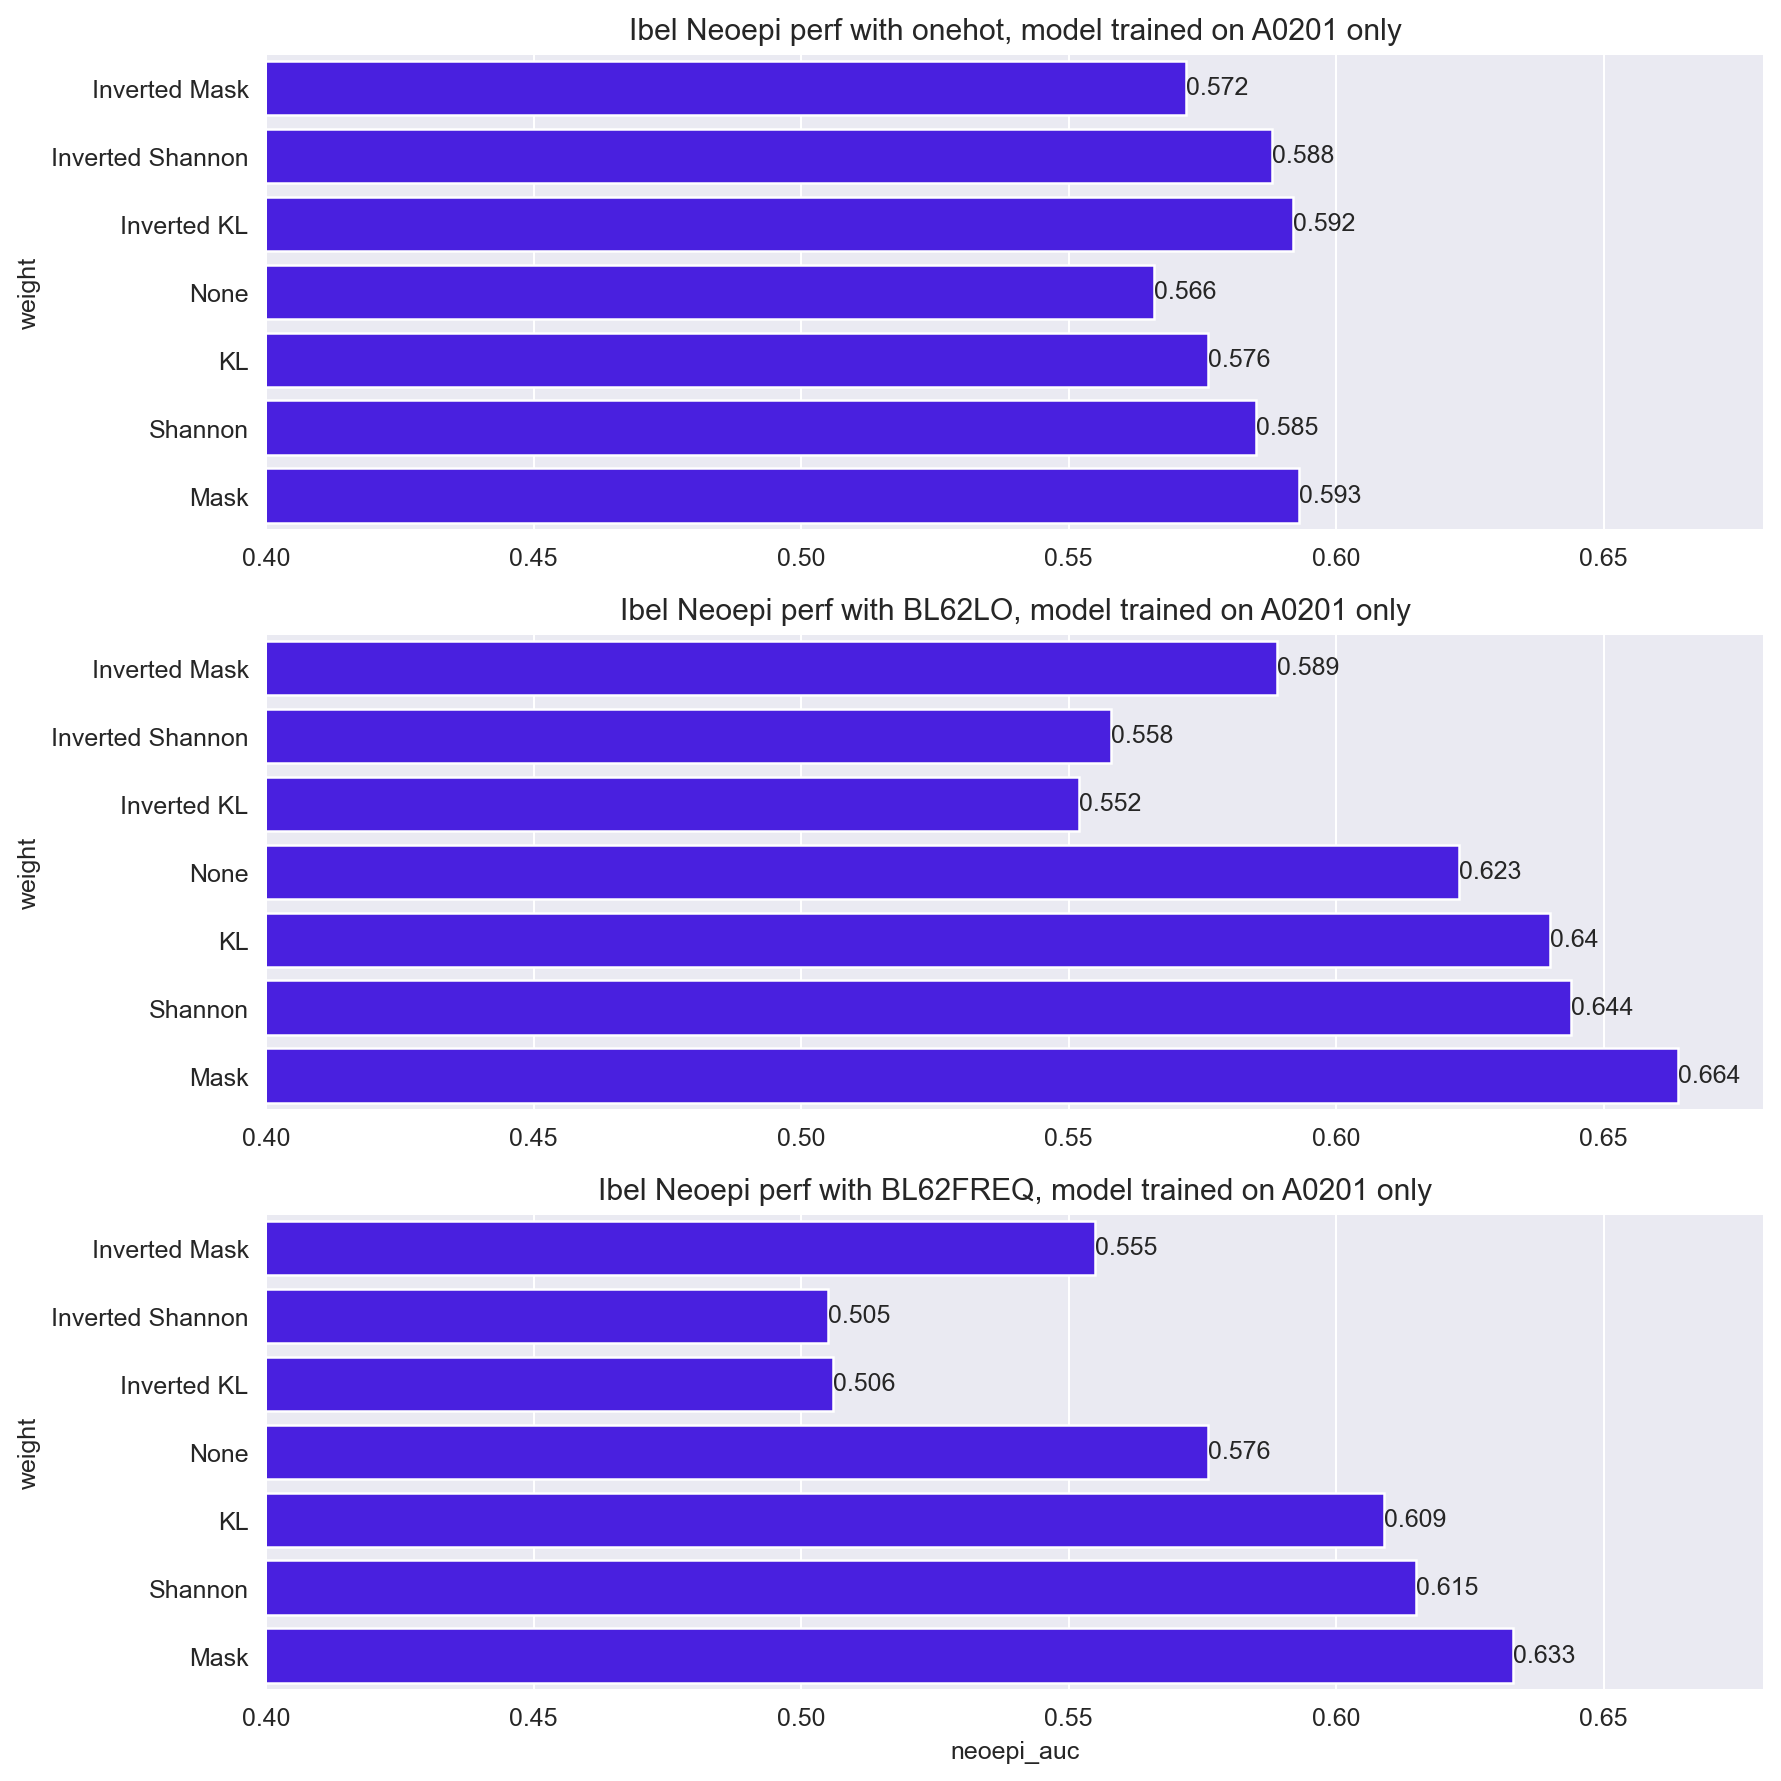

In [68]:
f,a = plt.subplots(3,1, figsize=(10,10))
sns.set_palette(HSV)
for i, encoding in enumerate(['onehot', 'BL62LO', 'BL62FREQ']):
    tm = df_a0201.query('encoding==@encoding')
    tm['neoepi_auc']=tm['neoepi_auc'].apply(lambda x: round(x,3))
    sns.barplot(data=tm, x='neoepi_auc', y='weight', hue='encoding', order=['Inverted Mask', 'Inverted Shannon', 'Inverted KL', 
                                                                     'None', 'KL', 'Shannon', 'Mask'], ax=a[i], orient='h')
    a[i].set_title(f'Ibel Neoepi perf with {encoding}, model trained on A0201 only')
    if i <2 : 
        a[i].set_xlabel('')
    else:
        # a[i].legend(bbox_to_anchor=(1.25, 3))
        pass
    a[i].set_xlim([.4, .68])
    a[i].bar_label(a[i].containers[0])
    a[i].legend([], frameon=False)
    # a[i].bar_label(a[i].containers[1])
f.tight_layout()

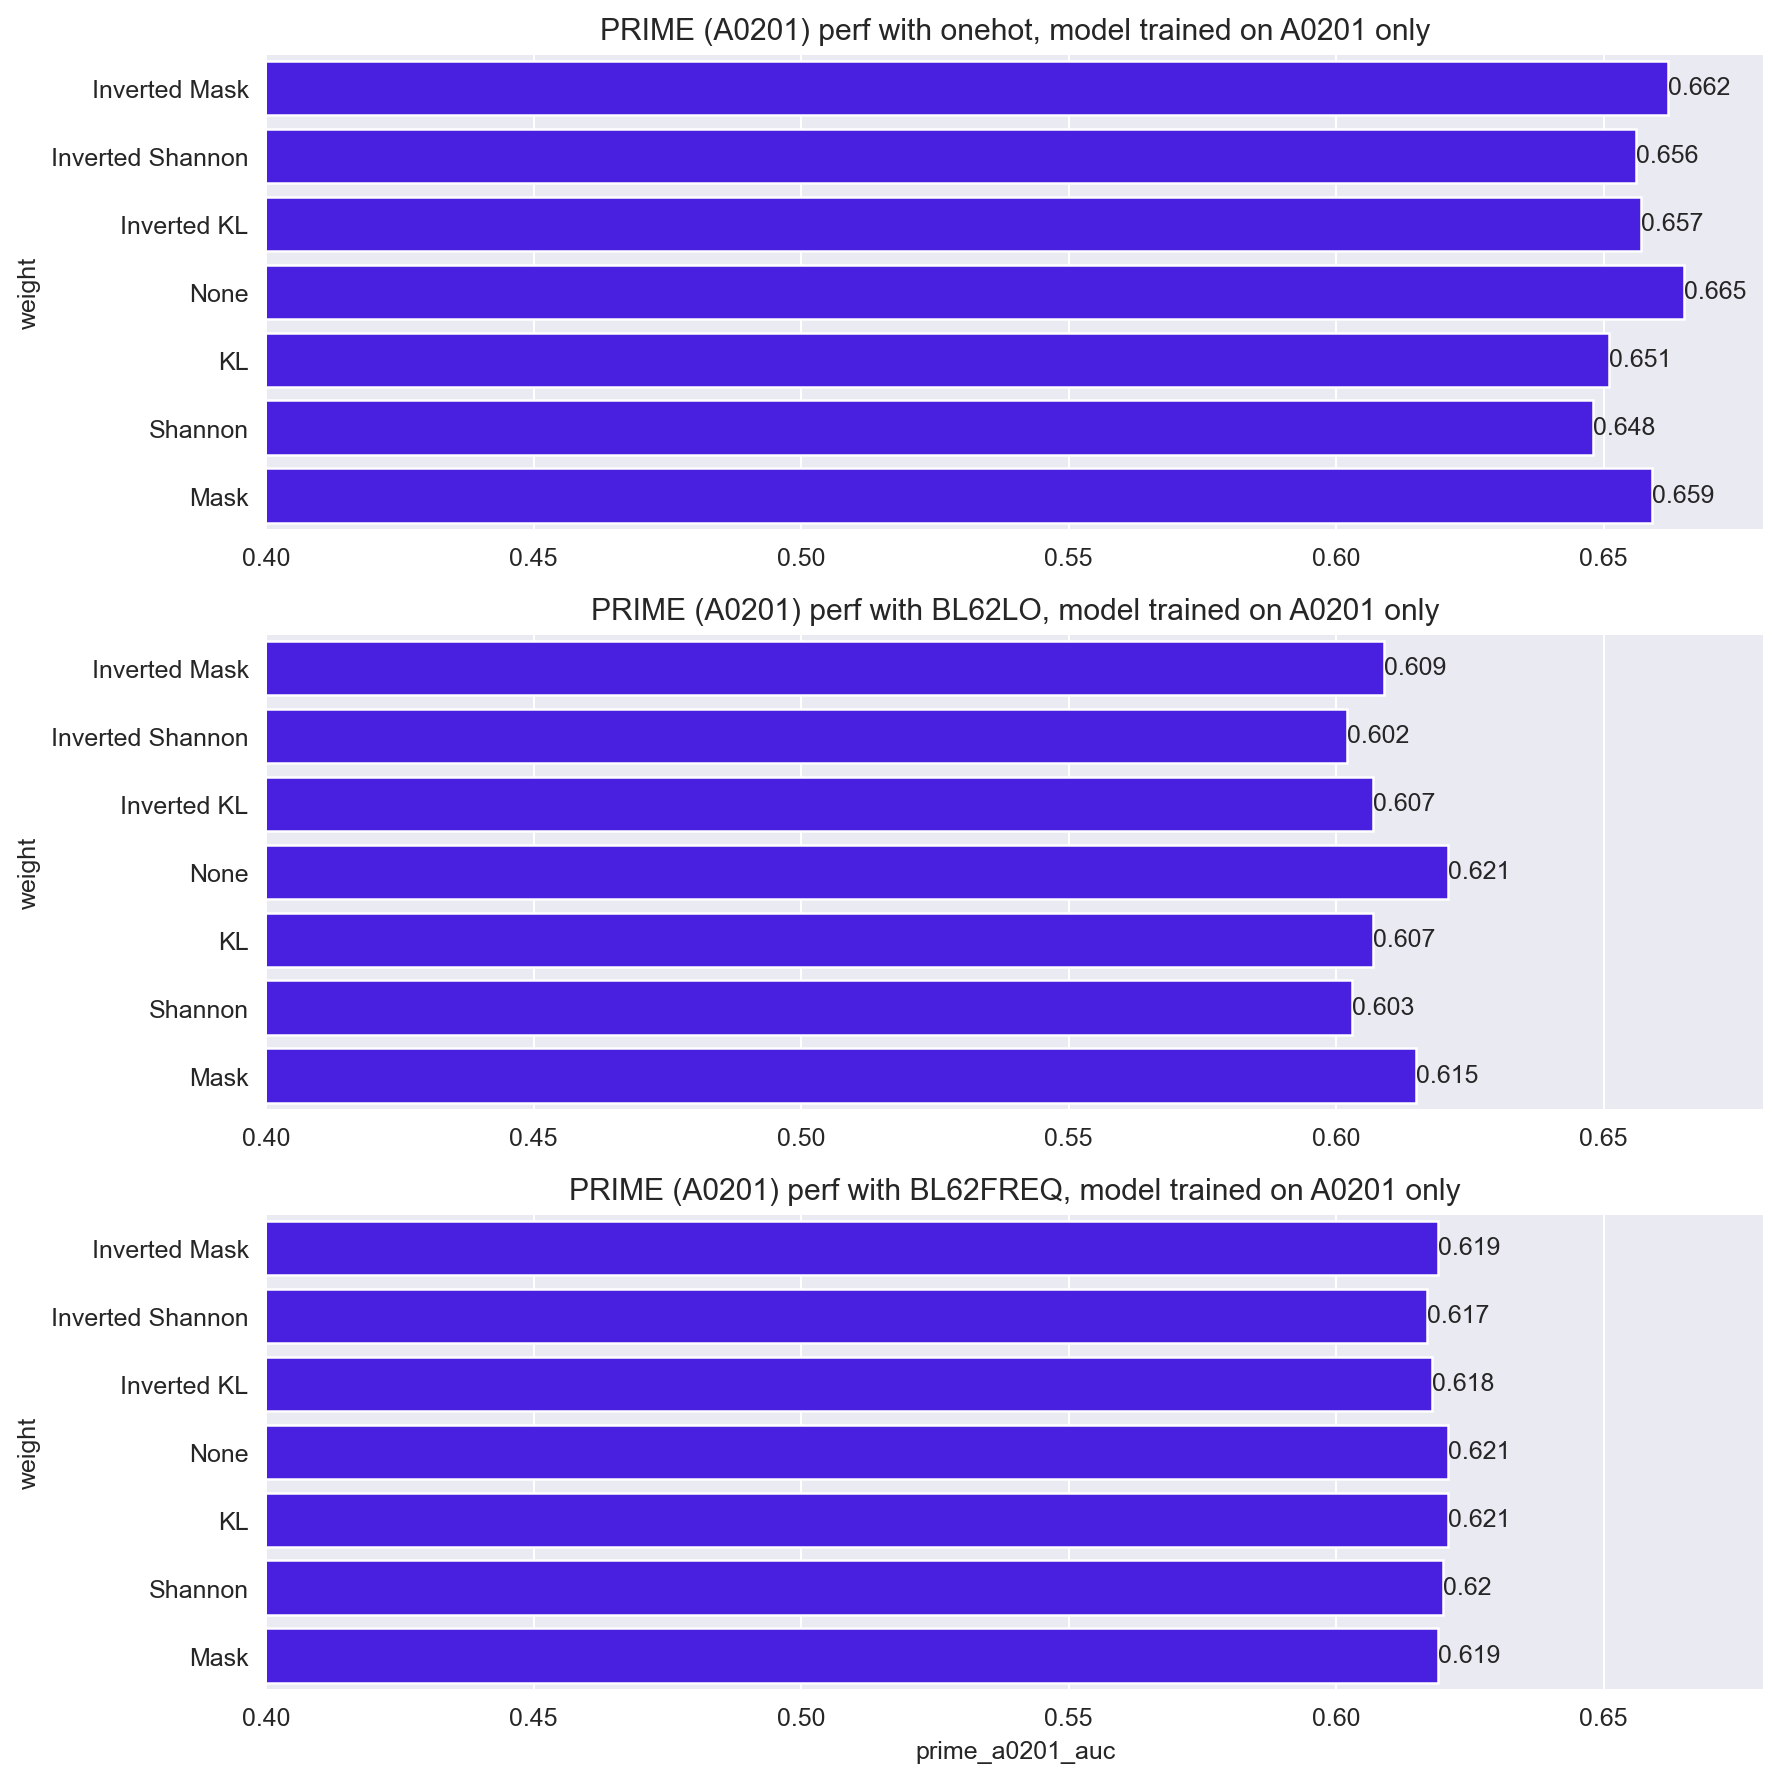

In [67]:
f,a = plt.subplots(3,1, figsize=(10,10))
sns.set_palette(HSV)
for i, encoding in enumerate(['onehot', 'BL62LO', 'BL62FREQ']):
    tm = df_a0201.query('encoding==@encoding')
    tm['prime_a0201_auc']=tm['prime_a0201_auc'].apply(lambda x: round(x,3))
    sns.barplot(data=tm, x='prime_a0201_auc', y='weight', hue='encoding', order=['Inverted Mask', 'Inverted Shannon', 'Inverted KL', 
                                                                     'None', 'KL', 'Shannon', 'Mask'], ax=a[i], orient='h')
    a[i].set_title(f'PRIME (A0201) perf with {encoding}, model trained on A0201 only')
    if i <2 : 
        a[i].set_xlabel('')
    else:
        # a[i].legend(bbox_to_anchor=(1.25, 3))
        pass
    a[i].set_xlim([.4, .68])
    a[i].bar_label(a[i].containers[0])
    a[i].legend([], frameon=False)
    # a[i].bar_label(a[i].containers[1])
f.tight_layout()

## Results Related

In [133]:
results_related = pkl_load('./results_related_mutation_scorecols.pkl')

In [138]:
results_related['mutation_score']['onehot']['None']['neoepi_results']['concatenated']['auc']

0.6054443053817271

In [ ]:
from copy import deepcopy
df_related = pd.DataFrame()
for encoding, v2 in results_related.items():
    for weight, v3 in v2.items():
        x = deepcopy(v3['neoepi_results']['concatenated'])
        del x['roc_curve']
        del x['pr_curve']
        tmp = pd.DataFrame(x, index=[0])
        tmp['evalset']='ibel_neoepi'
        tmp['encoding']=encoding
        tmp['weight']=weight
        df_related = df_related.append(tmp, ignore_index=True)
        # Prime related
        x = deepcopy(v3['cedar_related_results']['concatenated'])
        del x['roc_curve']
        del x['pr_curve']
        tmp = pd.DataFrame(x, index=[0])
        tmp['evalset']='cedar_related'
        tmp['encoding']=encoding
        tmp['weight']=weight
        df_related = df_related.append(tmp, ignore_index=True)
        
        x = deepcopy(v3['prime_related_results']['concatenated'])
        del x['roc_curve']
        del x['pr_curve']
        tmp = pd.DataFrame(x, index=[0])
        tmp['evalset']='prime_related'
        tmp['encoding']=encoding
        tmp['weight']=weight
        df_related = df_related.append(tmp, ignore_index=True)
df_related.reset_index(drop=True,inplace=True)

In [82]:
df_related.columns

Index(['auc', 'prauc', 'AP', 'auc_01', 'f1', 'accuracy', 'precision', 'recall',
       'evalset', 'encoding', 'weight'],
      dtype='object')

In [127]:
df_related.cols.unique()

array(['blsm_mut_score', 'mutation_score', 'ratio_rank',
       'blsm_mut_score-mutation_score', 'blsm_mut_score-ratio_rank',
       'mutation_score-ratio_rank',
       'blsm_mut_score-mutation_score-ratio_rank'], dtype=object)

In [139]:
df_related.query('recall>0').sort_values('auc', ascending=False).groupby(['evalset', 'encoding','weight']).agg(auc=('auc', 'std'))

auc
evalset       encoding weight               
cedar_related BL62FREQ Inverted KL       0.0
                       Inverted Mask     0.0
                       Inverted Shannon  0.0
                       KL                0.0
                       Mask              0.0
                       None              0.0
                       Shannon           0.0
              BL62LO   Inverted KL       0.0
                       Inverted Mask     0.0
                       Inverted Shannon  0.0
                       KL                0.0
                       Mask              0.0
                       None              0.0
                       Shannon           0.0
              onehot   Inverted KL       0.0
                       Inverted Mask     0.0
                       Inverted Shannon  0.0
                       KL                0.0
                       Mask              0.0
                       None              0.0
                       Shannon           0.0
prime_related BL62FREQ Inverted KL       0.0
                       Inverted Mask     0.0
                       Inverted Shannon  0.0
                       KL                0.0
                       Mask              0.0
                       None              0.0
                       Shannon           0.0
              BL62LO   Inverted KL       0.0
                       Inverted Mask     0.0
                       Inverted Shannon  0.0
                       KL                0.0
                       Mask              0.0
                       None              0.0
                       Shannon           0.0
              onehot   Inverted KL       0.0
                       Inverted Shannon  0.0
                       KL                0.0
                       Mask              0.0
                       None              0.0
                       Shannon           0.0

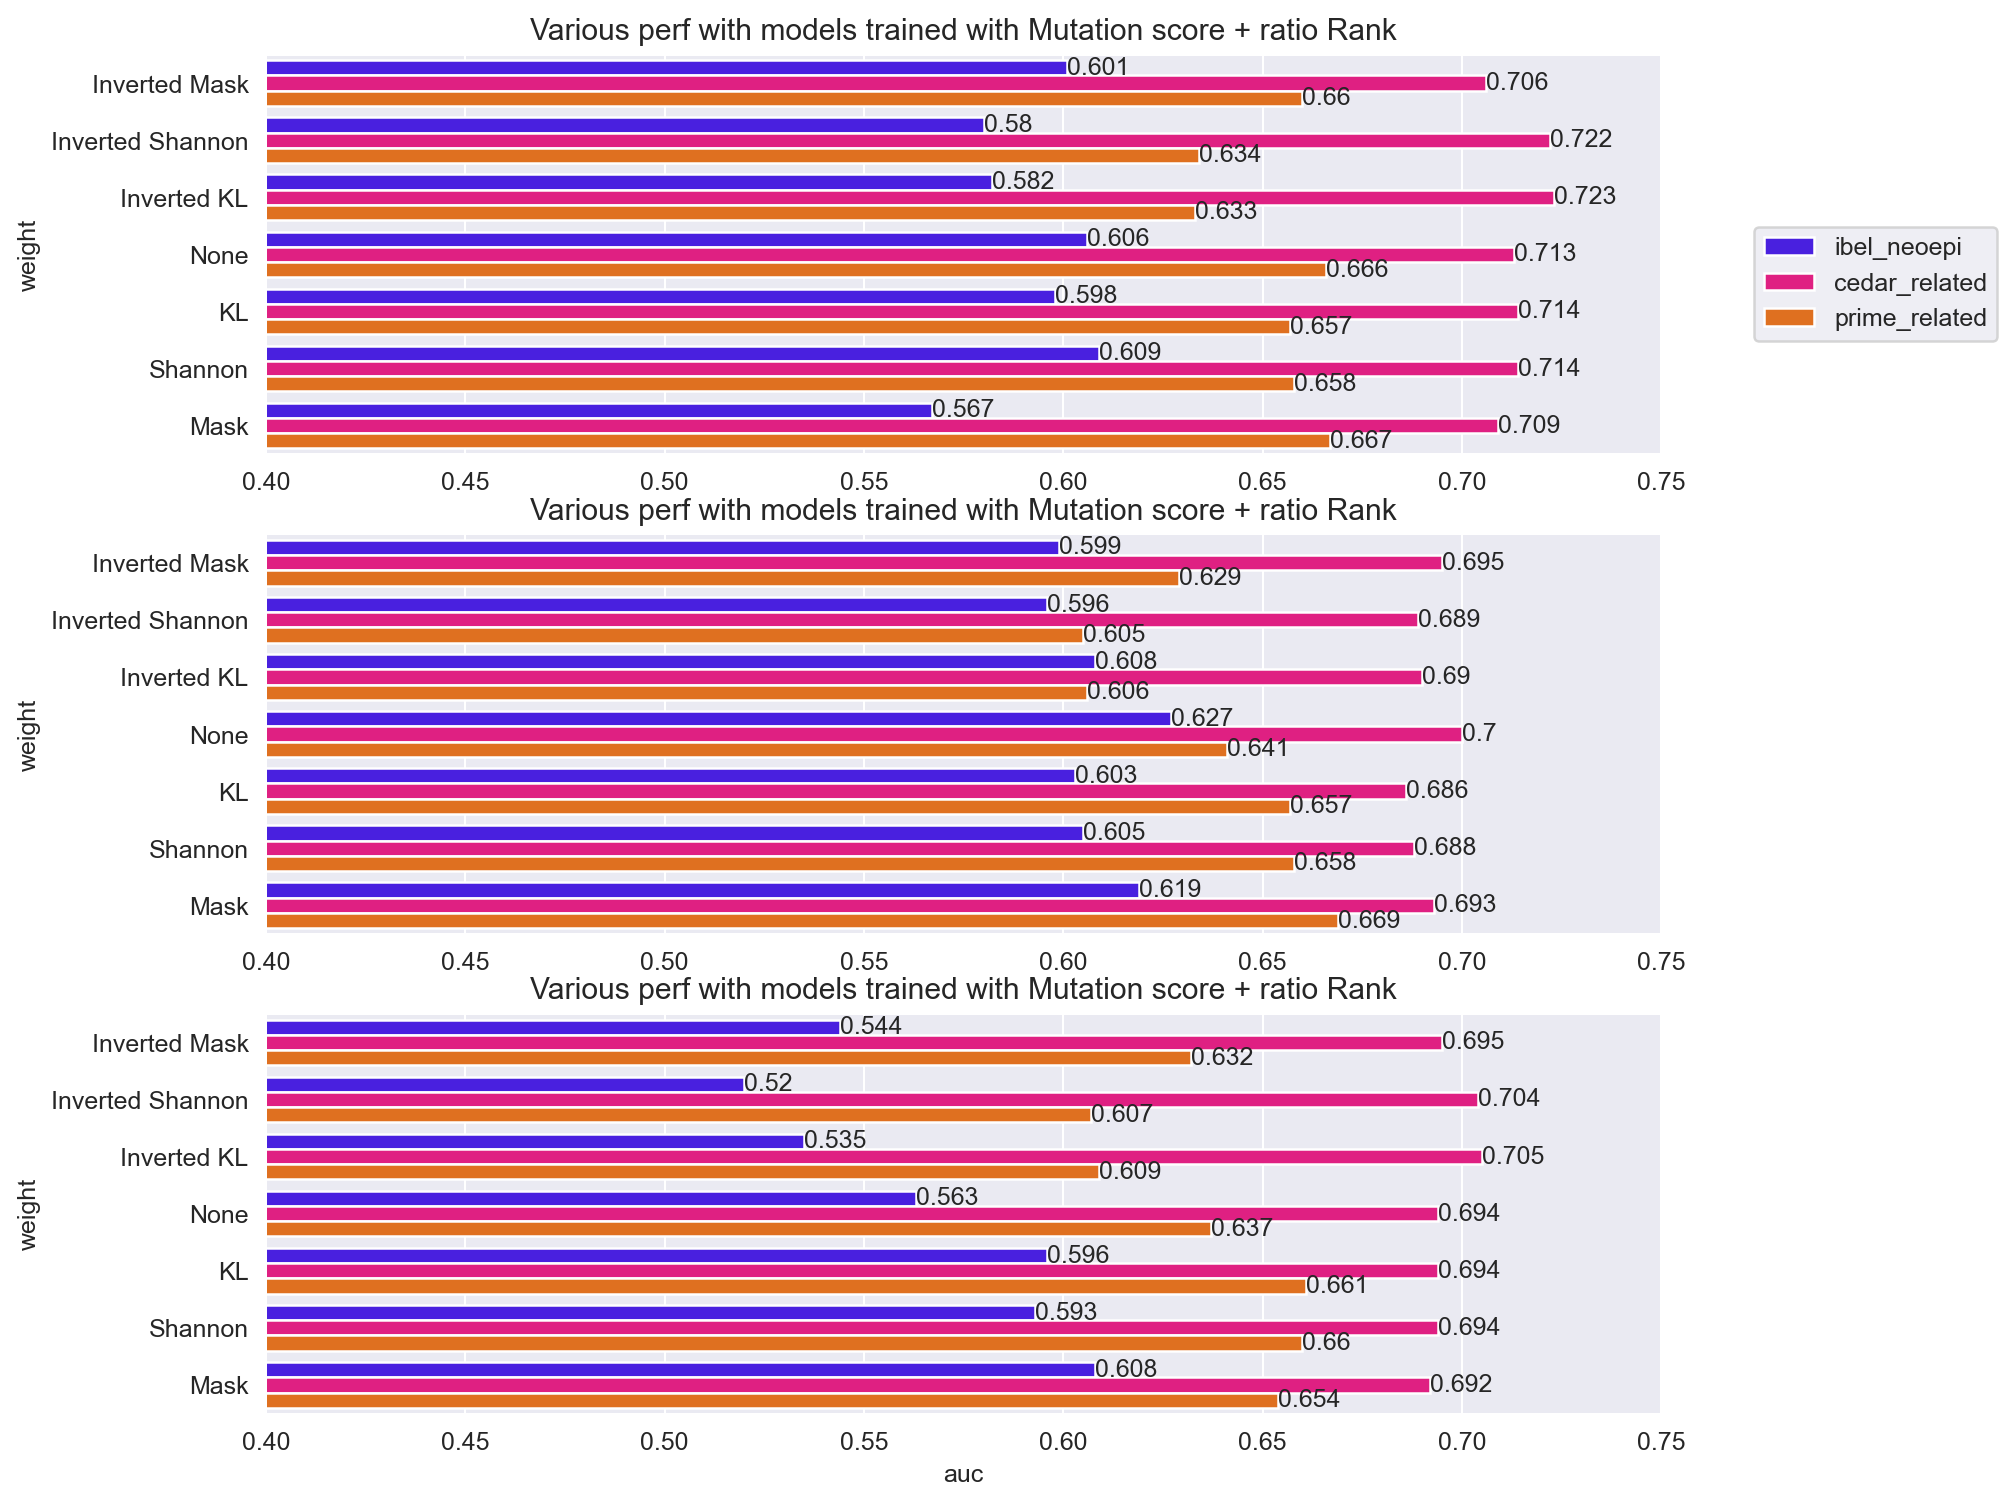

In [94]:
for encoding in ['onehot', 'BL62LO', 'BL62FREQ']:
    f,a = plt.subplots(3,1, figsize=(10,10))
    tm = df_related.query('encoding==@encoding')
    sns.set_palette(HSV)
    for i, encoding in enumerate(['onehot', 'BL62LO', 'BL62FREQ']):
        tm = df_related.query('encoding==@encoding')
        tm['auc']=tm['auc'].apply(lambda x: round(x,3))
        sns.barplot(data=tm, x='auc', y='weight', hue='evalset', order=['Inverted Mask', 'Inverted Shannon', 'Inverted KL', 
                                                                         'None', 'KL', 'Shannon', 'Mask'], ax=a[i], orient='h')
        a[i].set_title(f'Various perf with models trained with Mutation score + ratio Rank')
        if i <2 : 
            a[i].legend([], frameon=False)
            a[i].set_xlabel('')
        else:
            pass
        a[i].set_xlim([.4, .75])
        a[i].bar_label(a[i].containers[0])
        a[i].bar_label(a[i].containers[1])
        a[i].bar_label(a[i].containers[2])
    a[i].legend(bbox_to_anchor=(1.25, 3))
    f.tight_layout()

In [99]:
cedar_related_results_df = pd.read_csv('./cedar_results_related.csv')
prime_related_results_df = pd.read_csv('./prime_results_related.csv')

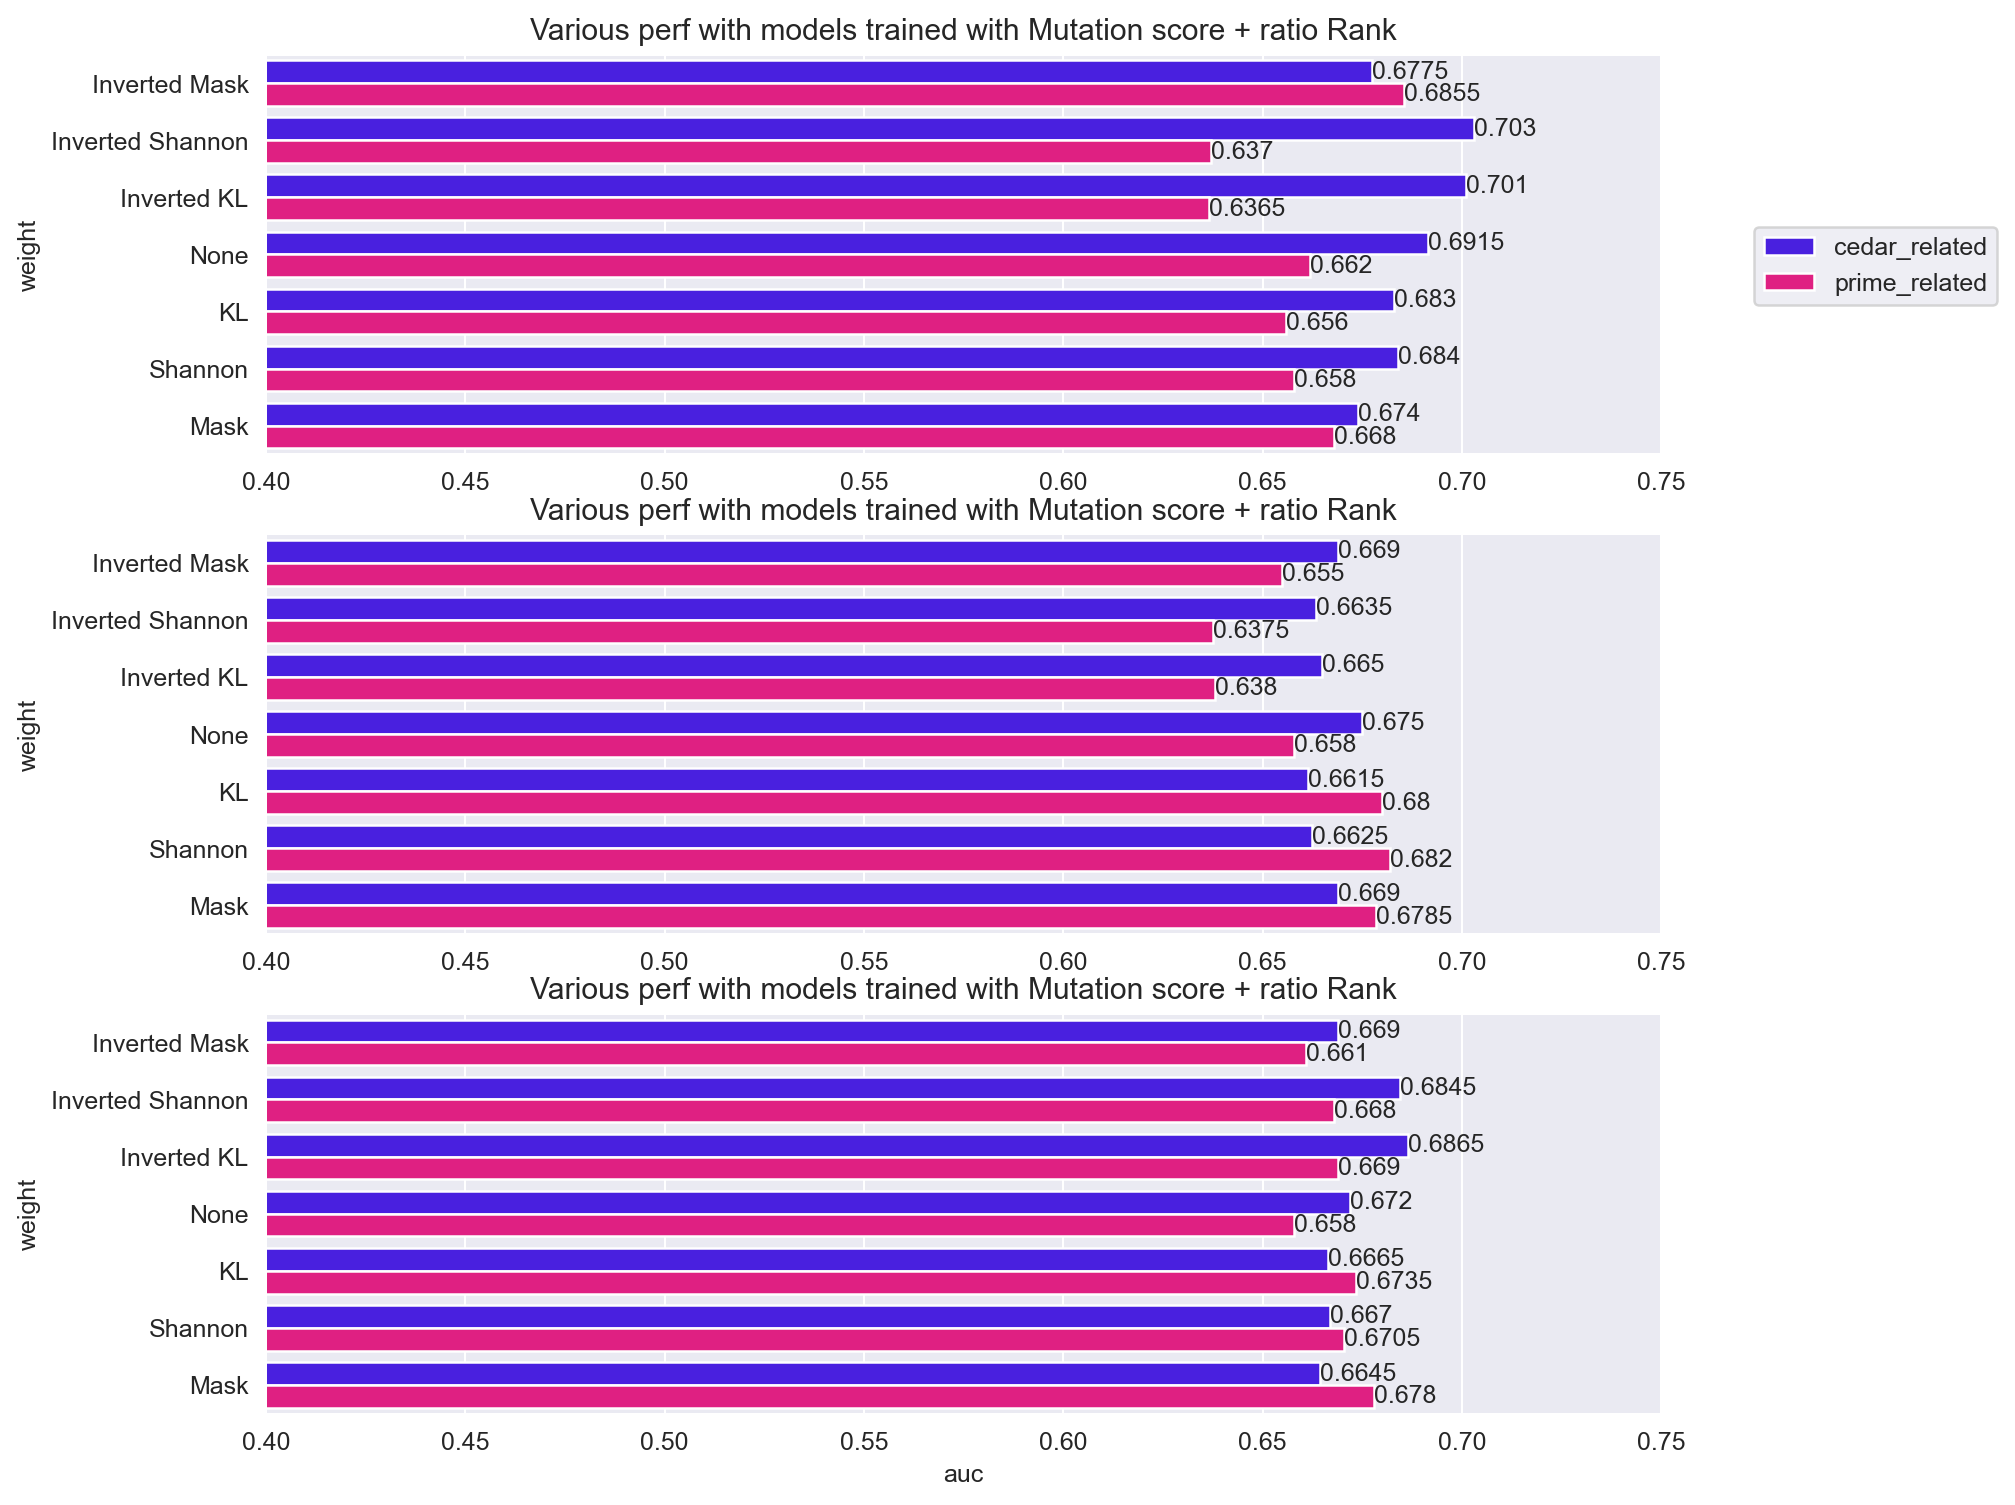

In [107]:
c_rel_tmp = cedar_related_results_df.groupby(['trainset', 'encoding','weight']).agg(auc=('auc','mean')).reset_index()
c_rel_tmp['evalset'] = 'cedar_related'
p_rel_tmp = prime_related_results_df.groupby(['trainset', 'encoding','weight']).agg(auc=('auc','mean')).reset_index()
p_rel_tmp['evalset'] = 'prime_related'

dd = pd.concat([c_rel_tmp, p_rel_tmp])
f,a = plt.subplots(3,1, figsize=(10,10))


for i, encoding in enumerate(['onehot', 'BL62LO', 'BL62FREQ']):
    tm = dd.query('encoding==@encoding')
    tm['auc']=tm['auc'].apply(lambda x: round(x,3))
    sns.barplot(data=tm, x='auc', y='weight', hue='evalset', order=['Inverted Mask', 'Inverted Shannon', 'Inverted KL', 
                                                                     'None', 'KL', 'Shannon', 'Mask'], ax=a[i], orient='h', errwidth=0)
    a[i].set_title(f'Various perf with models trained with Mutation score + ratio Rank')
    if i <2 : 
        a[i].legend([], frameon=False)
        a[i].set_xlabel('')
    else:
        pass
    a[i].set_xlim([.4, .75])
    a[i].bar_label(a[i].containers[0])
    a[i].bar_label(a[i].containers[1])
a[i].legend(bbox_to_anchor=(1.25, 3))
f.tight_layout()